In [ ]:
!pip install pandas-gbq google-auth
!pip install --upgrade google-cloud-bigquery google-auth google-auth-oauthlib google-auth-httplib2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.5/238.5 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.7/193.7 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: google-auth
    Found existing installation: google-auth 2.27.0
    Uninstalling google-auth-2.27.0:
      Successfully uninstalled google-auth-2.27.0
  Attempting uninstall: google-auth-httplib2
    Found existing installation: google-auth-httplib2 0.1.1
    Uninstalling google-auth-httplib2-0.1.1:
      Successfully uninstalled google-auth-httplib2-0.1.1
  Attempting uninstall: google-cloud-bigquery
    Found existing installation: google-cloud-bigquery 3.21.0
    Uninstalling google-cloud-bigquery-3.21.0:
      Successfully uninstalled google-cloud-bigquery-3.21.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires google-auth==2.27.0, but you have g

In [ ]:
# Importing necessary libraries
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import re
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats as stats

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery
from google.oauth2 import service_account

#
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from matplotlib.patches import Rectangle
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [ ]:
# This syncs your google account. Give permission to Google and follow the prompts.
auth.authenticate_user()

In [ ]:
project_id = "python-eda-project"
!gcloud config set project {project_id}

Updated property [core/project].


In [ ]:
# BigQuery 클라이언트 생성
client = bigquery.Client(project=project_id)

# SQL 쿼리 작성
query = """
SELECT *
FROM `python-eda-project.spotify.spotify_2023`
"""

# 쿼리 실행 및 DataFrame으로 변환
df = client.query(query).to_dataframe()

In [ ]:
df.head()

# 가람

---



## 인기 음악 요소 분석 : 인기 있는 노래에서 선호도 이해를 위해 음악 요소의 패턴 특징을 탐구
 - 스트리밍이 많은 곡들 간에 공통점이 있을 것이라고 가정

 ➡ 스트리밍이 많은 수대로 잘라내서 음악요소의 조합 분석

In [ ]:
# 'streams' 기준으로 내림차순 정렬
sorted_df = df.sort_values(by='streams', ascending=False, ignore_index=True)

# 상위 곡들에 대한 데이터프레임 생성
top_10_songs = sorted_df.head(10)
top_50_songs = sorted_df.head(50)
top_100_songs = sorted_df.head(100)
top_300_songs = sorted_df.head(300)
top_500_songs = sorted_df.head(500)
top_700_songs = sorted_df.head(700)
all_songs = sorted_df  # 전체 데이터프레임


# 데이터프레임과 라벨 리스트 생성
dataframes = [top_10_songs, top_50_songs, top_100_songs, top_300_songs, top_500_songs, top_700_songs, all_songs]
labels = ['Top 10', 'Top 50', 'Top 100', 'Top 300', 'Top 500', 'Top 700', 'All']

문자로 구성되어 있는 mode를 분석 및 시각화하기 위해 새로운 이진 컬럼을 생성

In [ ]:
print(df.columns)

분석에 활용할 음악 요소 :
bpm (분당 비트 수) ,danceability(댄스적합도), valence(밝기), energy(에너지), acousticness(어쿠스틱 정도), instrumentalness (연주 정도)
liveness(라이브 퍼포먼스 요소 존재), speechiness(말하는 단어의 양 정도)

위의 요소를 전체로 묶어 하나의 분석할 컬럼 리스트로 처리

In [ ]:
# 분석할 컬럼 리스트
columns_to_analyze = ['bpm', 'danceability', 'valence', 'energy', 'acousticness', 'instrumentalness', 'liveness', 'speechiness']

인기곡의 음악 요소 공통점 분석
- 스트리밍이 많은 기준으로 Top 100 안의 곡들을 곡의 선호도가 높은 편이라고 설정
- 인기가 좋은 곡들은 특정한 성향, 공통점을 강하게 보여질 것이라고 가정하여 전체 음악적 요소의 상관관계 분석 진행

In [ ]:
plt.figure(figsize = (10, 8))
corr = top_100_songs[['bpm','danceability','valence', 'energy', 'acousticness', 'instrumentalness','liveness', 'speechiness']].corr()
sns.heatmap(corr, annot = True, cmap = 'coolwarm', vmin =- 1, vmax = 1)
plt.title('TOP 100 Heatmap of Audio Features')
plt.tight_layout()
plt.show()

TOP 100 안에서 전체 음악적 요소가 합쳐진 큰 공통점이 보이지 않음

Top 100 안에서는 뚜렷한 공통 점이 보이지 않아서,다른 비교방식을 선정하여 진행
   전체 곡의 음악 요소와 top 100 곡의 음악 구성 요소 비교 분석

In [ ]:
#전체 리스트와 top 100곡 곡 구성요소 비교
sns.set_theme()

df_top100 = df.sort_values(by = ['streams'], ascending = False).head(100)

cols_plot = ['bpm',
 'key',
 'mode',
 'danceability',
 'valence',
 'energy',
 'acousticness',
 'instrumentalness',
 'liveness',
 'speechiness']

f, axes = plt.subplots(10, 2, figsize=(7, 20))

for i, col in zip(range(0,9), cols_plot):
    sns.histplot(df_top100, x = col, ax=axes[i,1], color = 'orange')

for i, col in zip(range(0,9), cols_plot):
    sns.histplot(df, x = col, ax=axes[i,0])

for ax, col in zip(axes[0,:], ['All', 'Top 100 Songs by stream']):
    ax.set_title(col, size=10)

f.tight_layout()
plt.savefig('그래프.png')

전체 곡과 상위 100곡에서 다른 몇가지 특징적인 부분들이 발견
- bpm : 전체 곡에선 100 이하의 곡이 가장 많은 반면, top 100 곡들은 주로 100 이상 120 사이정도로 분포
- key : 전체곡에선 C# 곡이 제일 많지만 D#을 제외하고 고르게 분포하는 편이나 top 100에선 C#,D,C,F 키의 노래가 제일 많음
- danceability : 전체 곡은 약 50%~80%까지 많이 보유하고 있지만 Top 100의 경우는 60% 이상 80% 미만으로 특정되어 분포되어있는 성향이 강함
- Valence : 역시 전체 곡에서 너무 어두운 곡을 제외하고 꽤 고르게 분포가 되어 있으나 top100의 경우는 많이 어두운 곡은 없고 50%정도의 밝기에 집중되어 있음
-energy : 전체에선 에너지가 적은 곡보다 상대적으로 55%이상 많은 곡들 위주로 분포 되어 있으나 TOP100에서는 60% 이상 80% 미만으로 특정 분포 성향이 강함

그외 3개 'acousticness','instrumentalness','liveness' 큰 차이점 없음
speechiness : 값이 너무 작아 비교 불가

MODE 비교
- 곡의 무드를 결정하는 모드와 관련하여 Major 장조 / Minor 단조의 분포도 비교
- BPM 분포도와 비슷할 것이라고 예측 : bpm 이 느리면 단조, 빠를수록 장조가 많을 것이다.

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(x='bpm', data=df, hue='mode', kde=True)
plt.title('Distribution of BPM by Mode')
plt.xlabel('BPM')
plt.ylabel('Count')
plt.show()

BPM이 느린곡들이 minor인 경우가 많기는 하나 전체적으로 major 곡이 압도적으로 많음

BPM 분포도 분석
- 최고, 최저 bpm 배치 : 사람들은 느리고, 아주 빠른 곡에 대한 선호도가 어느정도 일때 부터 생길까에 대한 궁금증

In [ ]:
bpm_min = []
bpm_max = []
bpm_avg = []
bpm_std = []

for df in dataframes:
    bpm_min.append(df['bpm'].min())
    bpm_max.append(df['bpm'].max())
    bpm_avg.append(df['bpm'].mean())
    bpm_std.append(df['bpm'].std())

plt.figure(figsize=(10, 6))

# Line for average BPM
plt.plot(labels, bpm_avg, marker='o', linestyle='-', color='skyblue', label='Average BPM')

# Line for max BPM
plt.plot(labels, bpm_max, marker='o', linestyle='-', color='lightcoral', label='Max BPM')

# Line for min BPM
plt.plot(labels, bpm_min, marker='o', linestyle='-', color='lightgreen', label='Min BPM')

# Line for std BPM
plt.plot(labels, bpm_std, marker='o', linestyle='-', color='gold', label='BPM Std Deviation')

plt.xlabel('Subset of Songs')
plt.ylabel('BPM')
plt.title('Distribution of BPM per Subsets')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 0.8))
plt.grid(True)

for i, (avg, max_val, min_val, std_val) in enumerate(zip(bpm_avg, bpm_max, bpm_min, bpm_std)):
    plt.text(i, avg, f'Avg: {avg:.2f}', ha='center', va='bottom', fontsize=10)
    plt.text(i, max_val, f'Max: {max_val:.2f}', ha='center', va='top', fontsize=10)
    plt.text(i, min_val, f'Min: {min_val:.2f}', ha='center', va='bottom', fontsize=10)
    plt.text(i, std_val, f'Std: {std_val:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

300위쯤 부터 빠른곡과 느린곡에 다양성에 대한 폭이 넓어짐 그러나 빠른곡에 비해서 제일 느린곡은 700위안에도 들지 못함
상대적으로 빠른곡에 대한 선호도가 조금 더 많다고 느껴짐

그렇다면 인기가 좋은 순서대로 좀더 선호가 강한 bpm이 있는지에 대해서 의문

In [ ]:
plt.figure(figsize=(12, 8))
bpm_avg = []

for i, df in enumerate(dataframes):
    plt.scatter([i] * len(df), df['bpm'], label=labels[i], alpha=0.7)
    avg = df['bpm'].mean()
    bpm_avg.append(avg)

plt.plot(range(len(dataframes)), bpm_avg, marker='o', linestyle='-', color='red', label='Average BPM')
plt.xlabel('Subset of Songs')
plt.ylabel('BPM')
plt.title('TOP - Distribution of BPM for Each Subsets')
plt.xticks(range(len(dataframes)), labels, rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)

plt.tight_layout()
plt.show()

top 10 은 모수 자체가 작아 큰 의미가 없으나 top 50, 100, 300의 경우 평균값 근처인 120 주위 100~140사이안에 분포도가 높은 점이 보임 또한 아주 빠르거나 아주 느린 곡의 개수 자체가 적음

그렇다면, bpm의 빠르기에 따라서 음악적 요소들이 관련이 있을 것이라고 가정
'danceability'댄스적합도, 'valence'밝기, 'energy'에너지 수준이 빠를수록 많이 높고 인기가 좋은 곡에 몰려있을 것이라고 예상됨

In [ ]:
columns_to_plot = ['danceability', 'valence', 'energy' ]

fig, axes = plt.subplots(2, 3, figsize=(15, 15))
colormap = plt.cm.get_cmap('plasma')

# 전체 데이터에 대한 산점도 그리기
for i, column in enumerate(columns_to_plot):
    axes[0, i].scatter(df['bpm'], df[column], c=df['streams'], cmap=colormap, alpha=0.7)
    axes[0, i].set_xlabel('BPM', fontsize=12)
    axes[0, i].set_ylabel(column, fontsize=12)
    axes[0, i].set_title(f'All Songs: {column} vs. BPM', fontsize=14)
    axes[0, i].grid(True)
    plt.colorbar(axes[0, i].collections[0], ax=axes[0, i], label='streams')

# 상위 100곡에 대한 산점도 그리기
for i, column in enumerate(columns_to_plot):
    axes[1, i].scatter(top_100_songs['bpm'], top_100_songs[column], c=top_100_songs['streams'], cmap=colormap, alpha=0.7)
    axes[1, i].set_xlabel('BPM', fontsize=12)
    axes[1, i].set_ylabel(column, fontsize=12)
    axes[1, i].set_title(f'Top 100 Songs: {column} vs. BPM', fontsize=14)
    axes[1, i].grid(True)
    plt.colorbar(axes[1, i].collections[0], ax=axes[1, i], label='streams')

# 레이아웃 조정 및 그래프 출력
plt.tight_layout()
plt.show()


생각보다 bpm과 댄스적합도, 밝기, 에너지에 대한 연관성이 매우 낮다고 보여짐

bpm이 빠르거나 느리다고 해서 댄스 적합도나 곡의 밝기, 에너지에 대해서는 크겨 연관이 없고 해당 조합도 스밍에 큰 영향을 끼치지 않는다고 보여짐

그렇다면 이 'danceability', 'valence', 'energy' 이 3요소는 어디와 연관성이 높은 것인가?
댄스 적합도와 밝기, 그리고 에너지를 비교 진행

In [ ]:
columns_to_plot = ['valence', 'energy' ]

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
colormap = plt.cm.get_cmap('viridis')

# 전체 데이터에 대한 산점도 그리기
for i, column in enumerate(columns_to_plot):
    axes[0, i].scatter(df['danceability'], df[column], c=df['streams'], cmap=colormap, alpha=0.7)
    axes[0, i].set_xlabel('Daceability', fontsize=12)
    axes[0, i].set_ylabel(column, fontsize=12)
    axes[0, i].set_title(f'All Songs: {column} vs. Danceability', fontsize=14)
    axes[0, i].grid(True)
    plt.colorbar(axes[0, i].collections[0], ax=axes[0, i], label='streams')

# 상위 100곡에 대한 산점도 그리기
for i, column in enumerate(columns_to_plot):
    axes[1, i].scatter(top_100_songs['danceability'], top_100_songs[column], c=top_100_songs['streams'], cmap=colormap, alpha=0.7)
    axes[1, i].set_xlabel('Danceability', fontsize=12)
    axes[1, i].set_ylabel(column, fontsize=12)
    axes[1, i].set_title(f'Top 100 Songs: {column} vs. Danceability', fontsize=14)
    axes[1, i].grid(True)
    plt.colorbar(axes[1, i].collections[0], ax=axes[1, i], label='streams')

# 레이아웃 조정 및 그래프 출력
plt.tight_layout()
plt.show()


In [ ]:
plt.savefig('bright.png')

Top100과 전체곡 다 뚜렷하게 연관성이 강하진 않지만 bpm에 비해서는 상대적으로 댄스적합도가 높을수록 밝기 및 에너지가 높음

그렇다면 Top 100 안에 가장 많은 음악적 요소들을 기준으로 다 갖추고 있는 곡은 몇곡이나 될까?
Top 100 안에서 bpm  100 이상 120 사이,
key : C#,D,C,F
danceability 는 60% 이상 80% 미만,
Valence  50%정도
energy 는 60% 이상 80% 미만의 곡

In [ ]:
# 필터링 조건
filtered_songs = top_100_songs[
    (top_100_songs['bpm'] >= 100) & (top_100_songs['bpm'] <= 120) &
    (top_100_songs['key'].isin(['C#', 'D','C','F'])) &
    (top_100_songs['danceability'] >= 60) & (top_100_songs['danceability'] < 80) &
    (top_100_songs['valence'] == 50) & (top_100_songs['valence'] <= 65) &
    (top_100_songs['energy'] >= 60) & (top_100_songs['energy'] < 80)
]

# 필터링된 곡 개수 출력
count_filtered_songs = len(filtered_songs)
print(f"Number of songs =: {count_filtered_songs}")

"0" 곡
최종 결론 = TOP 100 곡 안에 많은 분포를 가진 요소들은 있으나 음악요소가 전부 공통으로 동일하지 않다.

# 현서

---



## spotify top 100 노래의 월별 + 요일별 스트리밍 분석

###월별 분석
1. 월별 발매된 곡의 수, 스티리밍 수, 재생목록 포함 수, 외에 곡의 특징들 비교
2. 위의 분석 값들을 히트맵을 활용하여 스트리밍 수와 상관 관계 분석
3. 스트리밍 수가 가장 많았던 1월에 비해 그 다음달인 2월의 스트리밍수가 급감했기 때문에 anova 검정을 사용하여 비교 분석
4. 1월 다음으로 5월의 스트리밍 수가 높았으므로, 해당 월들도 anova 검정을 활용하여 분석



###요일별 분석
1. 월별 분석의 1번과 마찬가지로 비교
2. 스트리밍 수가 가장 많았던 금요일과 토요일의 anova 검정 비교
(값이 원하는 값으로 도출이 안 돼서 수정이 필요합니다)

요일별 분석에 필요한 요일 열 생성

In [ ]:
df['released_date'] = pd.to_datetime(df[['released_year', 'released_month', 'released_day']].rename(columns={'released_year': 'year', 'released_month': 'month', 'released_day': 'day'}))
# 요일 열 생성
df['day_of_week'] = df['released_date'].dt.day_name()


분석에 필요한 1-100위의 값들만 뽑아서 월별 데이터에 삽입

In [ ]:
# Filter spotify_df for 'in_spotify_charts' values between 1 and 100
spotify_df = df.loc[(df['in_spotify_charts'] <= 100) & (df['in_spotify_charts'] > 0)]

# Group by 'released_month' and calculate median values
monthly_stats = spotify_df.groupby(['released_month']).agg({
    'streams': 'sum',  # 월별 스트리밍 횟수
    'in_spotify_playlists': 'sum',  # 월별 스포티파이 플레이리스트 포함 수
    'bpm': 'median',
    'danceability': 'median',
    'valence': 'median',
    'energy': 'median',
    'acousticness': 'median',
    'liveness': 'median',
    'speechiness': 'median',
    'artist_count': 'count',

}).reset_index()

# 변경된 데이터프레임 확인
print(len(spotify_df))
print(monthly_stats)

515
    released_month      streams  in_spotify_playlists    bpm  danceability  \
0                1  60125374360                874674  123.5          67.5   
1                2  17768601460                174856  121.0          69.0   
2                3  24881558883                219345  119.5          70.0   
3                4  17832318933                146168  125.0          68.0   
4                5  30029983863                206309  124.0          75.0   
5                6  17026079885                136338  122.0          74.0   
6                7  20646252458                161744  125.0          69.0   
7                8  18239168035                155974  128.0          63.0   
8                9  25195598482                292127  116.5          67.0   
9               10  23316477235                235100  107.5          64.0   
10              11  21017576371                186666  118.0          70.0   
11              12  19891818996                126326  126.0

스트리밍 수를 기준으로 곡의 특징들을 넣음 (밑에 히트맵에서 상관관계가 낮은 특징들은 시각화하지 X)

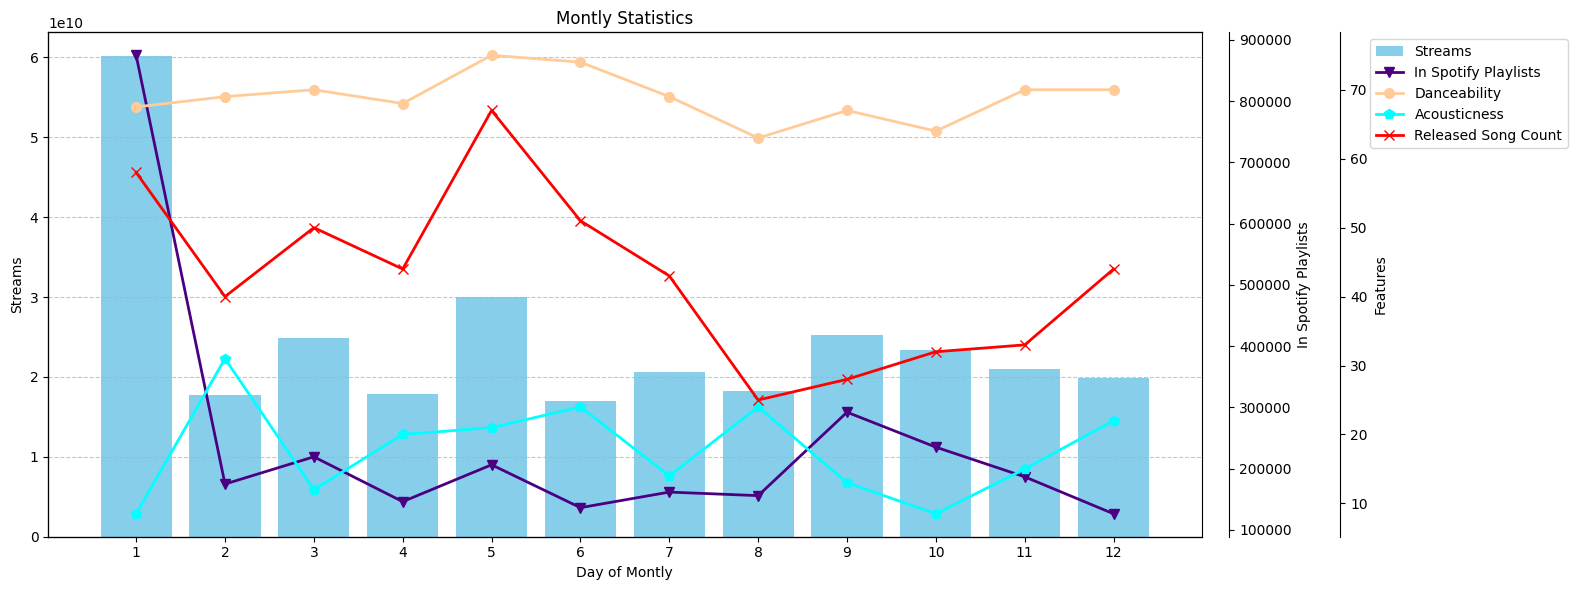

In [ ]:
fig, ax1 = plt.subplots(figsize=(16, 6))

ax1.bar(monthly_stats['released_month'], monthly_stats['streams'], color='skyblue', label='Streams')
ax1.set_xlabel('Day of Montly')
ax1.set_ylabel('Streams')
ax1.set_title('Montly Statistics')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# 첫 번째 y축과 공유하는 두 번째 y축 (Spotify 플레이리스트 포함 수)
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('outward', 20))
ax2.plot(monthly_stats['released_month'], monthly_stats['in_spotify_playlists'], '-v', color='indigo', markersize=7, linewidth=2, label='In Spotify Playlists')
ax2.set_ylabel('In Spotify Playlists')

# 추가적인 데이터 (BPM, Danceability, Valence, Energy, Acousticness, Liveness, Speechiness, Released song count)
ax3 = ax1.twinx()
# 축 위치 조정
ax3.spines['right'].set_position(('outward', 100))
#ax3.plot(monthly_stats['released_month'], monthly_stats['bpm'], '-s', color='#FF9999', markersize=7, linewidth=2, label='BPM')
ax3.plot(monthly_stats['released_month'], monthly_stats['danceability'], '-o', color='#FFCC99', markersize=7, linewidth=2, label='Danceability')
#ax3.plot(monthly_stats['released_month'], monthly_stats['valence'], '-^', color='#99FF99', markersize=7, linewidth=2, label='Valence')
#ax3.plot(monthly_stats['released_month'], monthly_stats['energy'], '-d', color='orange', markersize=7, linewidth=2, label='Energy')
ax3.plot(monthly_stats['released_month'],monthly_stats['acousticness'], '-p', color='cyan', markersize=7, linewidth=2, label='Acousticness')
#ax3.plot(monthly_stats['released_month'], monthly_stats['liveness'], '-x', color='magenta', markersize=7, linewidth=2, label='Liveness')
#ax3.plot(monthly_stats['released_month'], monthly_stats['speechiness'], '-v', color='yellow', markersize=7, linewidth=2, label='Speechiness')
ax3.plot(monthly_stats['released_month'], monthly_stats['artist_count'], '-x', color='red', markersize=7, linewidth=2, label='Released Song Count')
ax3.set_ylabel('Features')

# 범례 설정
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()

ax1.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, loc='upper left', bbox_to_anchor=(1.14, 1))
plt.xticks(range(1, 13))
plt.tight_layout()
plt.show()

# 1월에 다른 달보다 valence는 특히 높음 = 긍정성이 높은 음악이 스트리밍 많이 됨

# 1월에 스트리밍 수와 발매수, 스포티파이 재생목록 수가 가장 많음 => 그런데 2월에 모두 급감함 = 1월과 2월의 음악의 특징이 크게 달라지지 않았음(acoustiness의 급증한 것 제외)
# 5월애 스트르밍, 발매 수가 증가한 이유? = 특징 생각.. 그러나 재생목록 수가 큰 영향

#증감폭이 높은 건 앞에서 봤듯이 음악의 특징보다 스포티파이 내의 재생목록 수! 같은 흐름대로 증감 한다

전체 특징을 히트맵으로 시각화 한 뒤에, 상관관계가 있는 요소들만 뽑아서 다시 만들었습니다

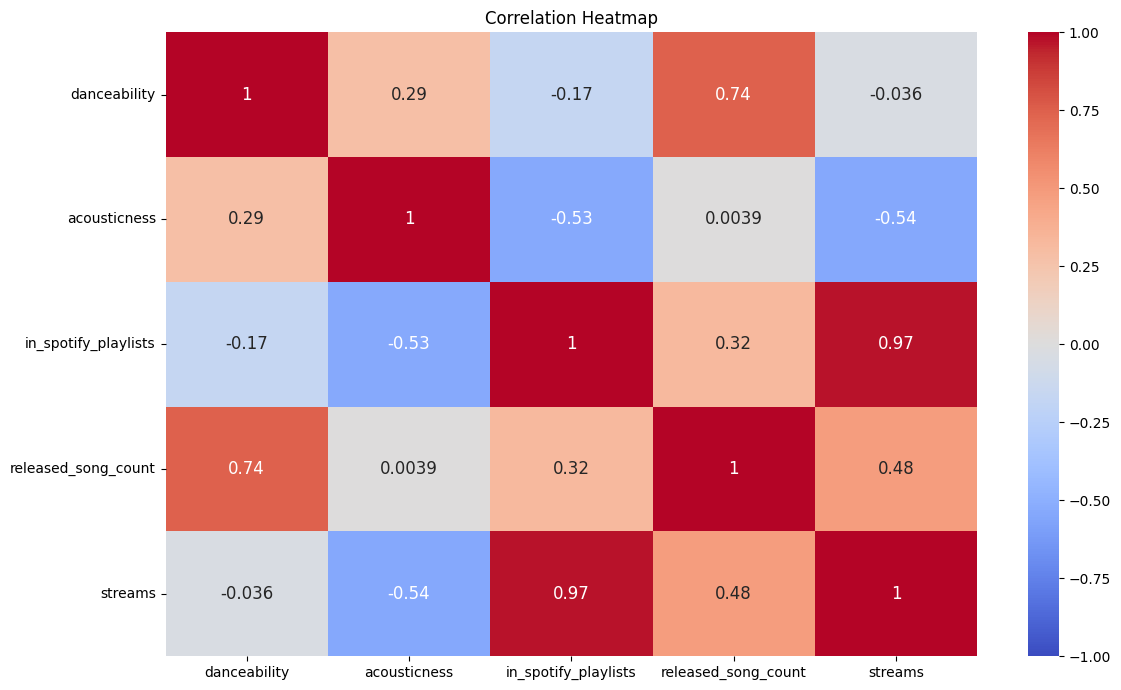

In [ ]:
monthly_stats = monthly_stats.rename(columns={'artist_count': 'released_song_count'})

features = ['danceability', 'acousticness', 'in_spotify_playlists', 'released_song_count']
target_features = ['streams']

correlation_matrix = monthly_stats[features + target_features].corr()

fig, axes = plt.subplots(1, 1, figsize=(12, 7))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, annot_kws={"size": 12}, ax=axes)

axes.set_title('Correlation Heatmap')

plt.tight_layout()

plt.show()


# 재생목록수와 스트리밍은 아주 높은 상관관계
# 발매 곡들에 댄스 음악이 많다. 정도

1월과 2월의 특징별 anova 비교
= 스트리밍 수가 가장 높은 1월에 비해 2월의 스트리밍 수가 급감했다!

ANOVA for streams:
  - F-statistic: 20.82356105614521
  - p-value: 0.00001
  - The difference is statistically significant (p < 0.05)
ANOVA for in_spotify_playlists:
  - F-statistic: 21.757965162518712
  - p-value: 0.00001
  - The difference is statistically significant (p < 0.05)
ANOVA for acousticness:
  - F-statistic: 11.895373784883526
  - p-value: 0.00084
  - The difference is statistically significant (p < 0.05)


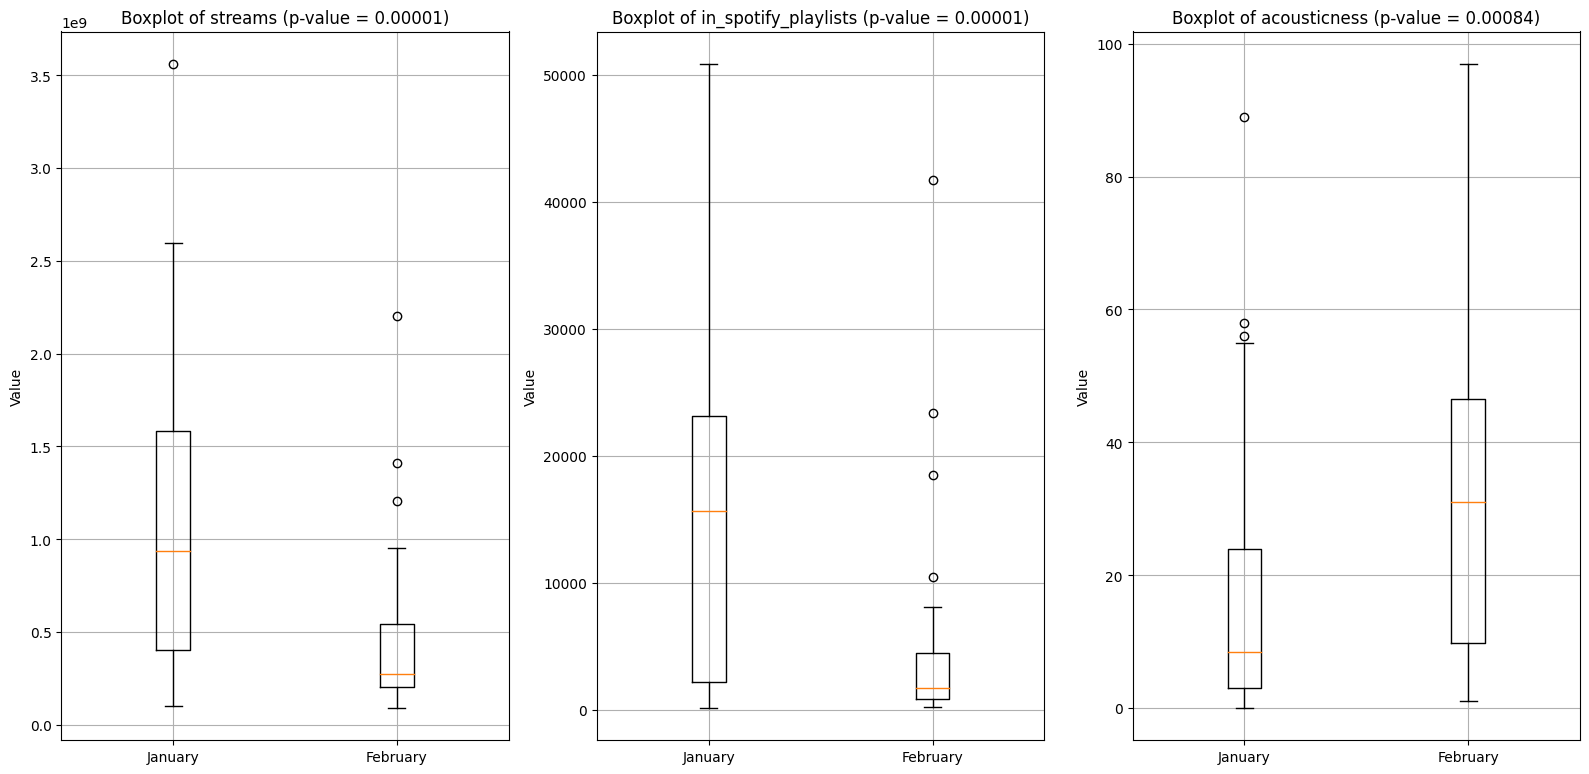

In [ ]:
january_february_df = spotify_df[spotify_df['released_month'].isin([1, 2])]

features = ['streams', 'in_spotify_playlists', 'bpm', 'danceability', 'valence',
            'energy', 'acousticness', 'liveness', 'speechiness' , 'in_spotify_charts', 'artist_count']

anova_results = {}
significant_features = []

for feature in features:
    groups = [january_february_df[january_february_df['released_month'] == month][feature].dropna().astype(float)
              for month in [1, 2]]

    f_statistic, p_value = f_oneway(*groups)

    anova_results[feature] = {'f_statistic': f_statistic, 'p_value': p_value}

    if p_value < 0.05:
        print(f"ANOVA for {feature}:")
        print(f"  - F-statistic: {f_statistic}")
        print(f"  - p-value: {p_value:.5f}")
        print("  - The difference is statistically significant (p < 0.05)")
        significant_features.append(feature)

plt.figure(figsize=(16, 8))

for i, feature in enumerate(significant_features, 1):
    plt.subplot(1, len(significant_features), i)
    data = [january_february_df[january_february_df['released_month'] == month][feature].dropna().astype(float)
            for month in [1, 2]]
    plt.boxplot(data)
    plt.title(f'Boxplot of {feature} (p-value = {anova_results[feature]["p_value"]:.5f})')
    plt.xticks([1, 2], ['January', 'February'])
    plt.ylabel('Value')
    plt.grid(True)

plt.tight_layout()
plt.show()


F-statistic: 20.82356105614521
F-통계량은 그룹 간의 변동과 그룹 내 변동의 비율을 나타냅니다. 높은 F-통계량은 그룹 간의 차이가 크다는 것을 의미합니다.
F = Between-group variance / within-group variance

p-value: 0.00001
p-값은 관찰된 데이터가 귀무 가설(여기서는 요일 간에 차이가 없다)을 지지할 확률입니다. p-값이 작을수록 (일반적으로 0.05보다 작으면) 귀무 가설을 기각하고 대립 가설(요일 간에 차이가 있다)을 지지합니다.

The difference is statistically significant (p < 0.05)
p-값이 0.05보다 작으므로, 요일 간에 스트림 수에 유의미한 차이가 있다는 결론을 내릴 수 있습니다. 요일별로 각 변수의 평균값이 차이가 있으며, 이는 단순히 우연에 의한 것이 아니다

1월과 5월의 anova 비교
스티리밍 수 각각 1,2 위

ANOVA for streams:
  - F-statistic: 30.273349627291882
  - p-value: 0.0000002080
  - The difference is statistically significant (p < 0.05)
ANOVA for in_spotify_playlists:
  - F-statistic: 51.25329759414418
  - p-value: 0.0000000001
  - The difference is statistically significant (p < 0.05)
ANOVA for danceability:
  - F-statistic: 5.938022205821239
  - p-value: 0.0162491758
  - The difference is statistically significant (p < 0.05)
ANOVA for acousticness:
  - F-statistic: 9.219342210820392
  - p-value: 0.0029239432
  - The difference is statistically significant (p < 0.05)


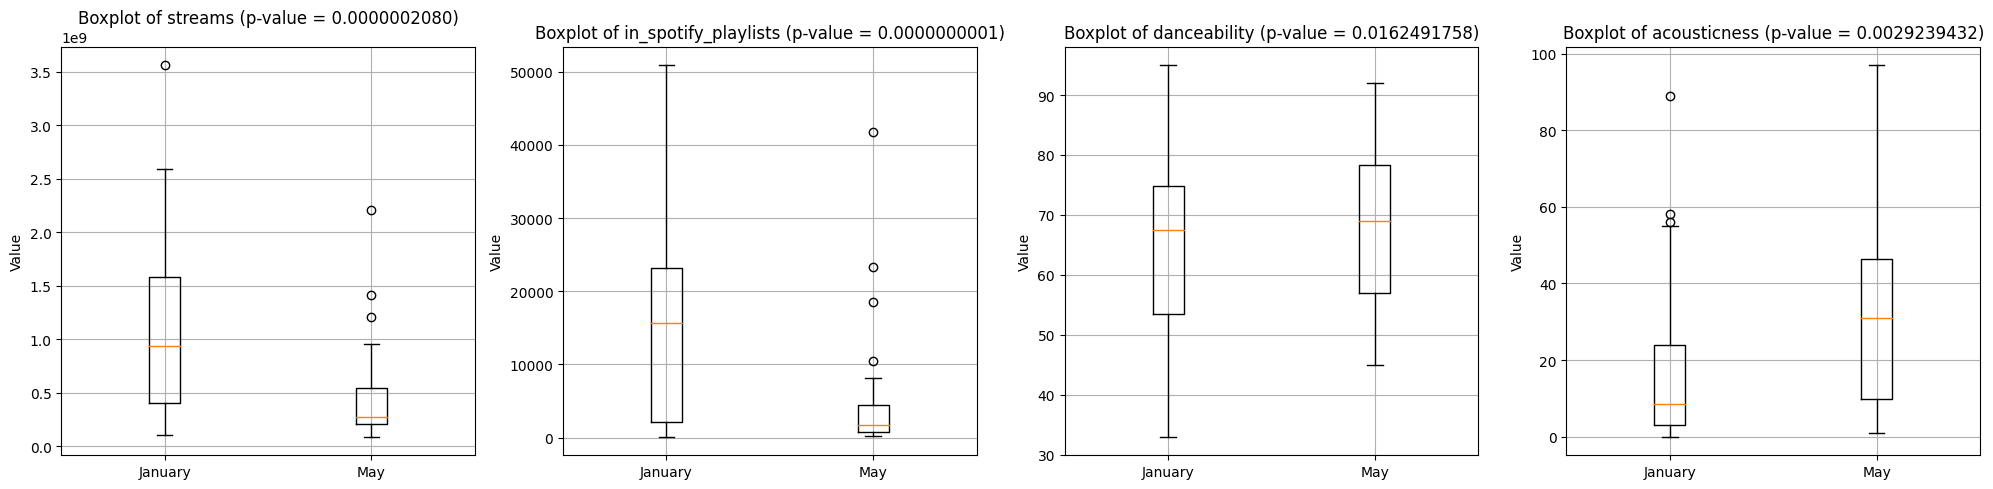

In [ ]:
january_may_df = spotify_df[spotify_df['released_month'].isin([1, 5])]


features = ['streams', 'in_spotify_playlists', 'bpm', 'danceability', 'valence',
            'energy', 'acousticness', 'liveness', 'speechiness' , 'in_spotify_charts', 'artist_count']

anova_results = {}
significant_features = []

for feature in features:
    groups = [january_may_df[january_may_df['released_month'] == month][feature].dropna().astype(float)
              for month in [1, 5]]

    f_statistic, p_value = f_oneway(*groups)

    anova_results[feature] = {'f_statistic': f_statistic, 'p_value': p_value}

    if p_value < 0.05:
        print(f"ANOVA for {feature}:")
        print(f"  - F-statistic: {f_statistic}")
        print(f"  - p-value: {p_value:.10f}")
        print("  - The difference is statistically significant (p < 0.05)")
        significant_features.append(feature)

plt.figure(figsize=(20, 5))

for i, feature in enumerate(significant_features, 1):
    plt.subplot(1, len(significant_features), i)
    data = [january_february_df[january_february_df['released_month'] == month][feature].dropna().astype(float)
            for month in [1, 2]]
    plt.boxplot(data)
    plt.title(f'Boxplot of {feature} (p-value = {anova_results[feature]["p_value"]:.10f})')
    plt.xticks([1, 2], ['January', 'May'])
    plt.ylabel('Value')
    plt.grid(True)

plt.tight_layout()
plt.show()

월별 데이터를 만든 것과 마찬가지로 1위 - 100위 순위의 곡들만 요일별 데이터에 삽입

In [ ]:
week_stats = spotify_df.groupby(['day_of_week']).agg({
    'streams': 'sum',  # 월별 스트리밍 횟수
    'in_spotify_playlists': 'sum',  # 월별 평균 스포티파이 플레이리스트 포함 수
    'bpm' : 'median',
    'danceability' : 'median', #트랙이 댄스에 얼마나 적합한지를 나타내는 척도입니다.
    'valence' : 'median', #트랙이 전달하는 음악적 긍정성.
    'energy' : 'median', # 트랙의 인지된 에너지.
    'acousticness' : 'median', #트랙이 얼마나 음향적인지를 나타내는 척도입니다.
    'instrumentalness' : 'median', #트랙에 보컬이 포함되어 있는지 여부를 측정합니다.
    'liveness' : 'median', #트랙에 라이브 요소나 음성 단어가 있는지 측정합니다.
    'speechiness' : 'median', #트랙이 음성 단어를 포함하는지 여부를 측정합니다.
    'artist_count' : 'count'

    # 다른 열들에 대해서도 평균 계산
}).reset_index()
print(week_stats)

  day_of_week       streams  in_spotify_playlists    bpm  danceability  \
0      Friday  133313668333               1041573  121.0          68.0   
1      Monday   24587923794                312278  116.0          73.0   
2    Saturday    8904688014                140281  120.0          69.0   
3      Sunday   12764280750                171296  121.5          70.0   
4    Thursday   41997689693                376697  125.0          74.0   
5     Tuesday   39153054812                568443  122.0          70.0   
6   Wednesday   35249503565                305059  124.0          68.0   

   valence  energy  acousticness  instrumentalness  liveness  speechiness  \
0     50.0    65.0          18.0               0.0      12.0          5.0   
1     53.0    73.0          12.5               0.0      11.5          5.0   
2     53.5    67.0          19.0               0.0      11.0          6.0   
3     43.5    62.5          16.0               0.0      13.5          4.5   
4     58.0    68.0    

요일별 데이터 특징 비교

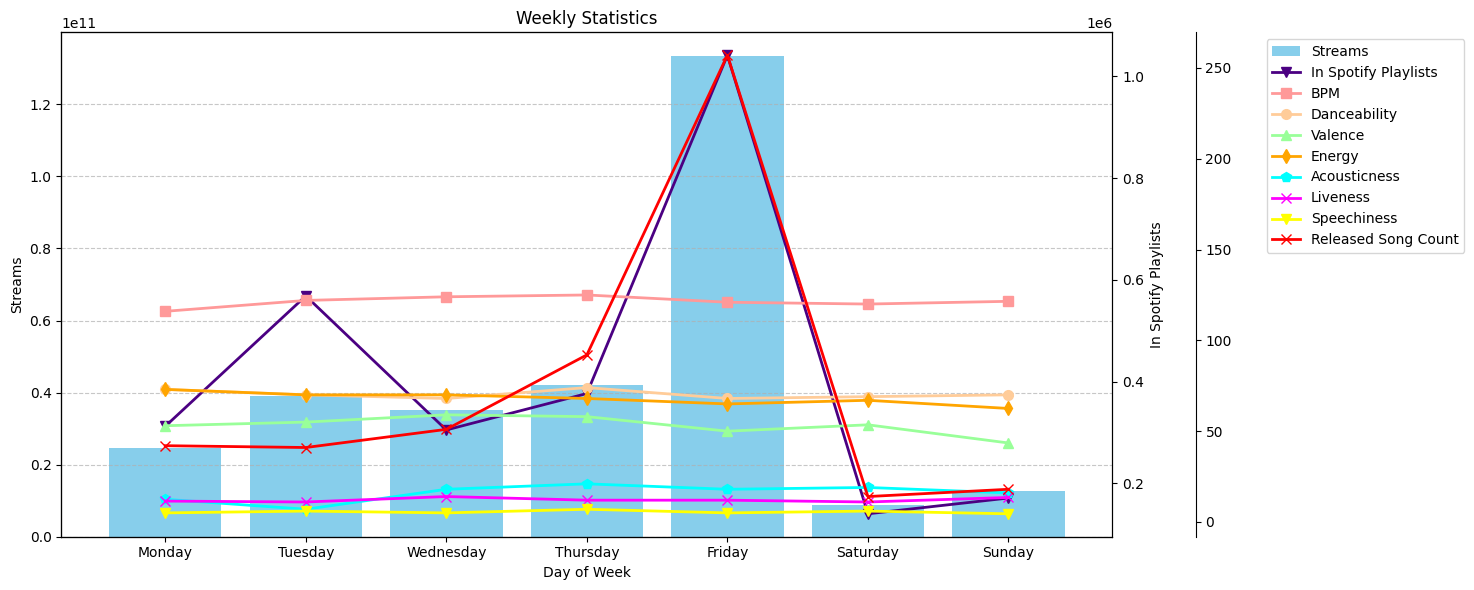

In [ ]:
day_mapping = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}

week_stats['day_number'] = week_stats['day_of_week'].map(day_mapping)
week_stats = week_stats.sort_values(by='day_number')

fig, ax1 = plt.subplots(figsize=(15, 6))

# 바 차트 (스트리밍 수)
ax1.bar(week_stats['day_of_week'], week_stats['streams'], color='skyblue', label='Streams')
ax1.set_xlabel('Day of Week')
ax1.set_ylabel('Streams')
ax1.set_title('Weekly Statistics')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# 첫 번째 y축과 공유하는 두 번째 y축 (Spotify 플레이리스트 포함 수)
ax2 = ax1.twinx()
ax2.plot(week_stats['day_of_week'], week_stats['in_spotify_playlists'], '-v', color='indigo', markersize=7, linewidth=2, label='In Spotify Playlists')
ax2.set_ylabel('In Spotify Playlists')

# 추가적인 데이터 (BPM, Danceability, Valence, Energy, Acousticness, Liveness, Speechiness, Released song count)
ax3 = ax1.twinx()

# 축 위치 조정
ax3.spines['right'].set_position(('outward', 60))

ax3.plot(week_stats['day_of_week'], week_stats['bpm'], '-s', color='#FF9999', markersize=7, linewidth=2, label='BPM')
ax3.plot(week_stats['day_of_week'], week_stats['danceability'], '-o', color='#FFCC99', markersize=7, linewidth=2, label='Danceability')
ax3.plot(week_stats['day_of_week'], week_stats['valence'], '-^', color='#99FF99', markersize=7, linewidth=2, label='Valence')
ax3.plot(week_stats['day_of_week'], week_stats['energy'], '-d', color='orange', markersize=7, linewidth=2, label='Energy')
ax3.plot(week_stats['day_of_week'], week_stats['acousticness'], '-p', color='cyan', markersize=7, linewidth=2, label='Acousticness')
ax3.plot(week_stats['day_of_week'], week_stats['liveness'], '-x', color='magenta', markersize=7, linewidth=2, label='Liveness')
ax3.plot(week_stats['day_of_week'], week_stats['speechiness'], '-v', color='yellow', markersize=7, linewidth=2, label='Speechiness')
ax3.plot(week_stats['day_of_week'], week_stats['artist_count'], '-x', color='red', markersize=7, linewidth=2, label='Released Song Count')

# 범례 설정
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()

ax1.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, loc='upper left', bbox_to_anchor=(1.14, 1))

plt.tight_layout()
plt.show()

#월별 분석과 마찬가가지로 음악적 특징보다 발매 횟수와 재생목록 포함이 스트리밍에 영향을 끼침

스트리밍 수가 가장 많은 금요일과, 가장 작은 토요일 비교 = 재생목록 포함 수에 영향이 있을 것이다


In [ ]:
data2 = {
    'day_of_week': ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday'],
    'streams': [133313668333, 24587923794, 8904688014, 12764280750, 41997689693, 39153054812, 35249503565],
}

In [ ]:
dff = pd.DataFrame(data2)

# Convert streams to high or low based on median
median_streams = dff['streams'].median()
dff['high_streams'] = dff['streams'] > median_streams

# Convert day_of_week to dummy variables
dff = pd.get_dummies(dff, columns=['day_of_week'], drop_first=False)

# Independent variables (X) and dependent variable (y)
X = dff.drop(['streams', 'high_streams'], axis=1)
y = dff['high_streams']

# Fit logistic regression model
log_model = LogisticRegression()
log_model.fit(X, y)

# Print results
print(f'Coefficients: {log_model.coef_}')
print(f'Intercept: {log_model.intercept_}')
print(f'Score: {log_model.score(X, y)}')

Coefficients: [[ 0.45958091 -0.34472259 -0.34472259 -0.34472259  0.45958091  0.45958091
  -0.34472259]]
Intercept: [-0.29771258]
Score: 1.0


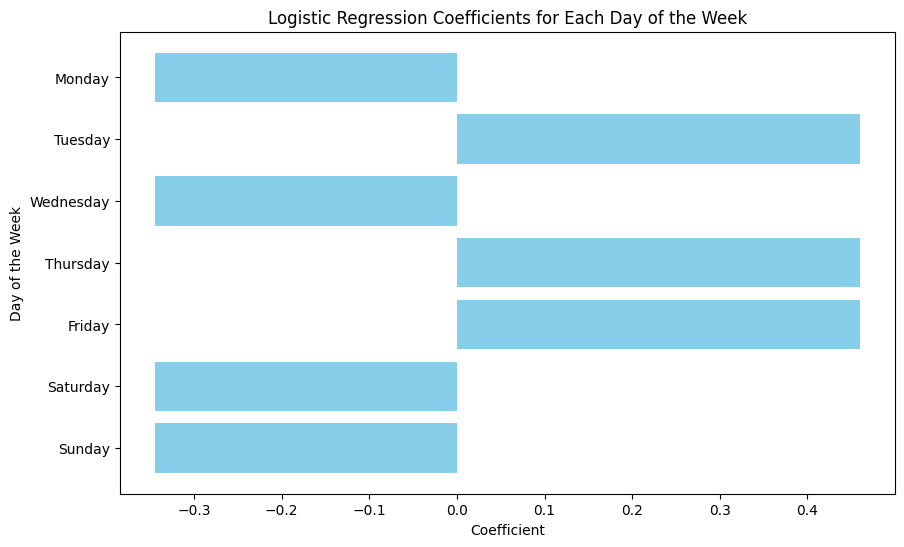

In [ ]:
coefficients = log_model.coef_[0]
days = X.columns

# Create a DataFrame for the coefficients and days
coef_df = pd.DataFrame({'Day': days, 'Coefficient': coefficients})

# Specify the desired order of days
day_order = ['day_of_week_Monday', 'day_of_week_Tuesday', 'day_of_week_Wednesday',
             'day_of_week_Thursday', 'day_of_week_Friday', 'day_of_week_Saturday', 'day_of_week_Sunday']

# Sort the DataFrame based on the specified order
coef_df['Day'] = pd.Categorical(coef_df['Day'], categories=day_order, ordered=True)
coef_df = coef_df.sort_values('Day', ascending=False)

# Map the column names to readable day names
coef_df['Day'] = coef_df['Day'].map({
    'day_of_week_Monday': 'Monday',
    'day_of_week_Tuesday': 'Tuesday',
    'day_of_week_Wednesday': 'Wednesday',
    'day_of_week_Thursday': 'Thursday',
    'day_of_week_Friday': 'Friday',
    'day_of_week_Saturday': 'Saturday',
    'day_of_week_Sunday': 'Sunday'
})

# Plot the coefficients
plt.figure(figsize=(10, 6))
plt.barh(coef_df['Day'], coef_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient')
plt.ylabel('Day of the Week')
plt.title('Logistic Regression Coefficients for Each Day of the Week')
plt.show()

Coefficients (회귀 계수): 각 요일에 대한 회귀 계수, 정 요일에 대한 더미 변수에 따라 스트리밍 수가 높을 확률이 얼마나 변하는지를 보여준다

Intercept (절편): 모든 독립 변수가 0일 때의 로그 오즈(log odds)를 나타냅니다. 즉, 기본 상태에서 스트리밍 수가 높을 확률에 대한 베이스라인

Score (모델 정확도): 모델이 주어진 데이터에서 약 85.71%의 경우를 정확하게 예측

회귀 계수 해석:

-0.36003863: 월요일, 토요일, 일요일, 화요일, 수요일의 더미 변수에 대한 계수입니다. 이 값은 해당 요일이 스트리밍 수가 높을 확률을 감소시키는 정도를 의미합니다.
0.44325117: 목요일과 금요일의 더미 변수에 대한 계수입니다. 이 값은 해당 요일이 스트리밍 수가 높을 확률을 증가시키는 정도를 의미합니다.
예를 들어, 목요일이 다른 요일에 비해 스트리밍 수가 높을 확률을 더 증가시키는 것으로 해석할 수 있습니다.

절편 해석:

절편 값인 -0.21525599는 모든 요일 더미 변수가 0일 때 (즉, 기준 요일로 설정된 요일에서) 스트리밍 수가 높을 확률의 로그 오즈(log odds)를 나타냅니다.
모델 정확도:

85.71%의 정확도는 모델이 상당히 높은 정확도로 데이터를 설명하고 예측함을 의미합니다. 이 값은 모델이 훈련 데이터에서 높은 스트리밍 수를 가지는지 여부를 얼마나 잘 분류하는지를 보여줍니다.
결론
이 모델은 특정 요일에 스트리밍 수가 높을 확률을 예측하는 데 사용될 수 있습니다. 목요일과 금요일은 스트리밍 수가 높을 확률을 증가시키는 반면, 월요일, 토요일, 일요일, 화요일, 수요일은 스트리밍 수가 높을 확률을 감소시킵니다. 모델의 정확도는 85.71%로, 데이터를 잘 설명하고 예측하는 것으로 보입니다.


In [ ]:
data3 = {
    'day_of_week': ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday'],
    'streams': [133313668333, 24587923794, 8904688014, 12764280750, 41997689693, 39153054812, 35249503565],
    'in_spotify_playlists': [1041573, 312278, 140281, 171296, 376697, 568443, 305059],
    'bpm': [121.0, 116.0, 120.0, 121.5, 125.0, 122.0, 124.0],
    'danceability': [68.0, 73.0, 69.0, 70.0, 74.0, 70.0, 68.0],
    'valence': [50.0, 53.0, 53.5, 43.5, 58.0, 55.0, 59.0],
    'energy': [65.0, 73.0, 67.0, 62.5, 68.0, 70.0, 70.0],
    'acousticness': [18.0, 12.5, 19.0, 16.0, 21.0, 7.0, 18.0],
    'instrumentalness': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    'liveness': [12.0, 11.5, 11.0, 13.5, 12.0, 11.0, 14.0],
    'speechiness': [5.0, 5.0, 6.0, 4.5, 7.0, 6.0, 5.0],
    'artist_count': [257, 42, 14, 18, 92, 41, 41],
}

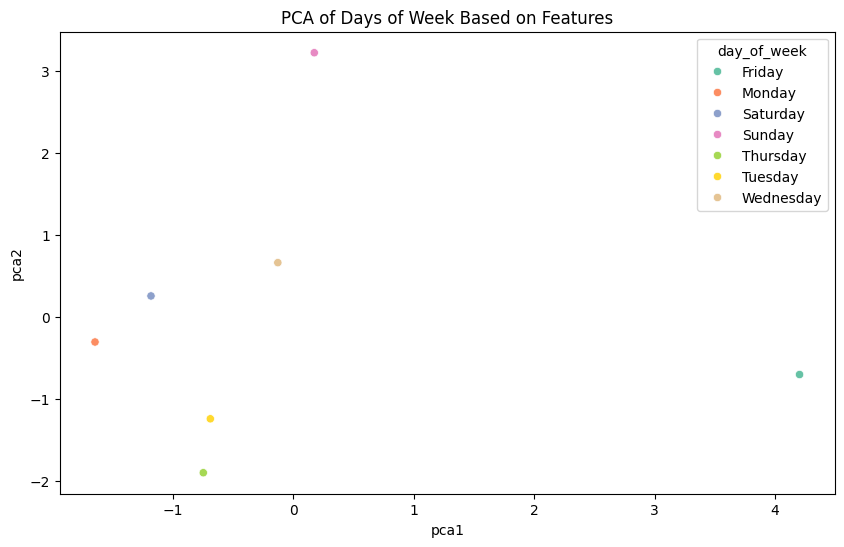

In [ ]:

s_df = pd.DataFrame(data3)

# PCA 변환
pca = PCA(n_components=2)  # 2차원으로 축소

s_df_numeric = s_df.drop(columns=['day_of_week'])
scaler = StandardScaler()
spotify_scaled = scaler.fit_transform(s_df_numeric)
spotify_pca = pca.fit_transform(spotify_scaled)

s_df['pca1'] = spotify_pca[:, 0]
s_df['pca2'] = spotify_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='pca1', y='pca2', hue='day_of_week', data=s_df, palette='Set2')
plt.title('PCA of Days of Week Based on Features')
plt.show()


X축 (pca1): 주성분 1 (Principal Component 1)을 나타냅니다. 데이터의 분산을 최대한 설명하는 방향

Y축 (pca2): 주성분 2 (Principal Component 2)를 나타냅니다. 주성분 1과 직교하며, 데이터의 추가적인 분산을 설명

Friday는 다른 요일들과 확연히 구분되는 위치에 있습니다. 이는 Friday의 데이터 특성이 다른 요일과 크게 다름을 시사합니다.
Sunday도 다른 요일들과 비교적 멀리 떨어져 있으며, 이는 Sunday의 특성 역시 독특함을 나타냅니다.
나머지 요일들은 비교적 가까운 위치에 있으며, 이는 이들의 데이터 특성이 비슷함을 나타낼 수 있습니다.

주성분 분석의 효과: PCA를 통해 고차원 데이터를 2차원으로 축소함으로써, 데이터의 주요 패턴을 시각적으로 파악할 수 있습니다. 각 요일의 데이터 분포가 어떻게 다른지를 한눈에 볼 수 있습니다.

# 승훈

---



## 장르에 대한 인기 요소 분석


---
음악적 특성을 다음과 같은 컬럼으로 지정

*   bpm
*   danceability
*   valence
*   energy
*   acousticness
*   instrumentalness
*   liveness
*   speechiness

음악적 특성을 기준으로 군집화하여 장르 예측 및 클러스터 내 인기 요소 분석


### 적정 클러스터 개수 확인

---

가설에 대한 분석을 진행하기 위해 우선 데이터셋에는 장르에 대한 데이터가 없기 때문에 군집화를 통해 장르 예측을 해보려합니다.

군집화 방법으로 K-means Clustering을 사용할 것인데 진행하기 앞서 K-means Clustering의 적정 클러스터 개수를 파악하기 위해 `Elbow Method`와 `Silhouette Score` 를 사용하였습니다.

*   Elbow Method: K-Means 군집화에서 최적의 군집(클러스터) 개수를 찾기 위한 방법
*   Silhouette Score: 군집화 결과의 품질을 평가하는 지표

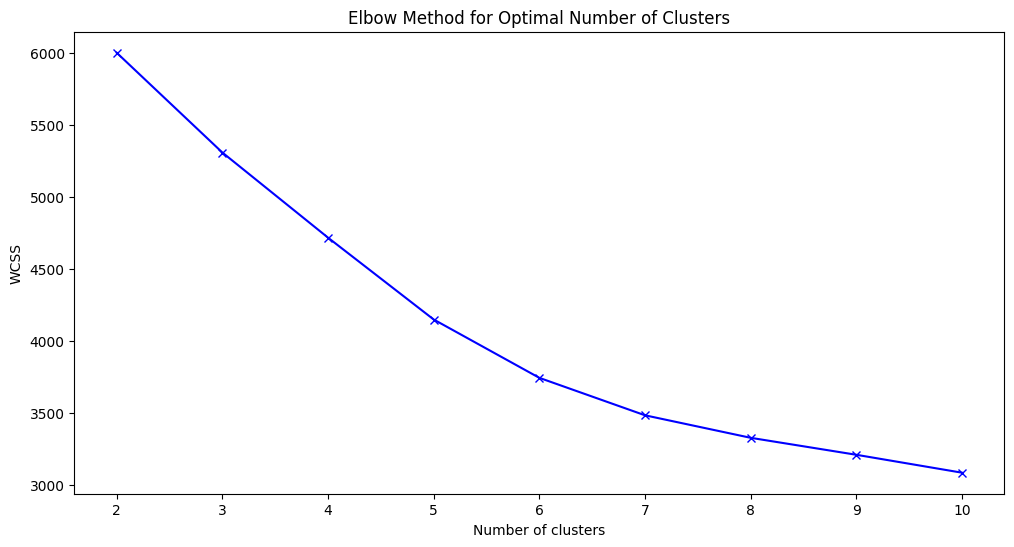

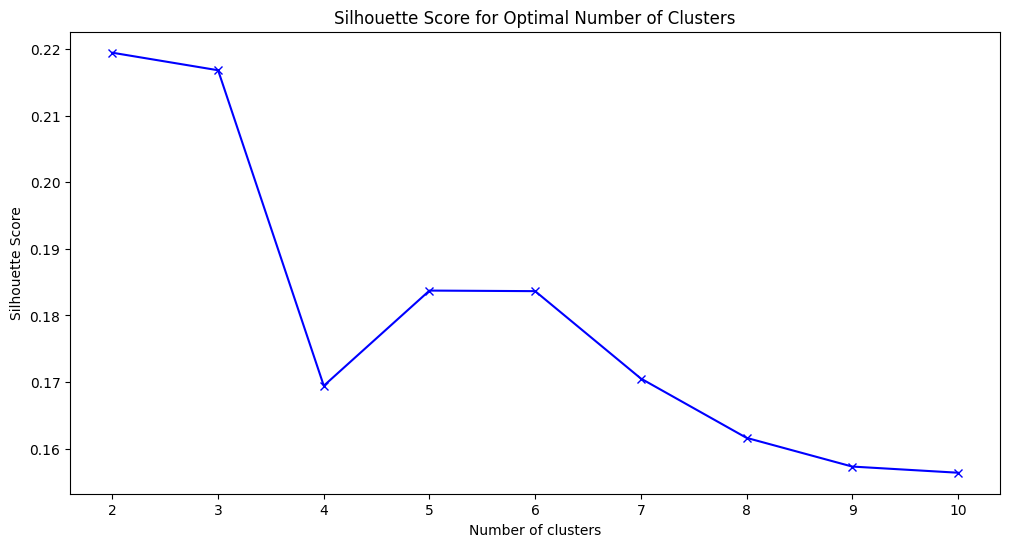

Number of Clusters         WCSS  Silhouette Score
0                   2  6003.738875          0.219478
1                   3  5309.788062          0.216843
2                   4  4717.630899          0.169441
3                   5  4148.464111          0.183741
4                   6  3742.657985          0.183655
5                   7  3482.259303          0.170529
6                   8  3325.727964          0.161614
7                   9  3207.681263          0.157301
8                  10  3083.069686          0.156374

In [ ]:
# 필요한 열만 선택하여 새로운 데이터프레임 생성
features = ['bpm', 'danceability', 'valence', 'energy', 'acousticness', 'instrumentalness', 'liveness', 'speechiness']
music_features = df[features]

# 데이터 스케일링
scaler = StandardScaler()
music_features_scaled = scaler.fit_transform(music_features)

# 엘보우 방법을 사용하여 적절한 클러스터 수 찾기
wcss = []
silhouette_scores = []
K = range(2, 11)  # 2에서 10까지 클러스터 수를 테스트

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(music_features_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(music_features_scaled, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# WCSS 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(K, wcss, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

# 실루엣 점수 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.show()

# 클러스터 개수와 각각의 WCSS 및 실루엣 점수 출력
optimal_results = pd.DataFrame({'Number of Clusters': K, 'WCSS': wcss, 'Silhouette Score': silhouette_scores})
optimal_results

Elbow Method는 그래프에서 WCSS가 급격히 감소하다가 완만해지는 지점을 찾는데 단어 그대로 팔꿈치 처럼 꺽이는 모습을 보이는 지점이 적절한 개수를 의미합니다. 첫 세 구간보다 비교적 완만해지는 구간인 5 부근이 적정 클러스터 개수이고 Silhouette Score는 클러스터의 품질을 나타내며, 값이 클수록 클러스터가 잘 구분되었음을 의미합니다. 그래프에서 2, 3 지점이 높은 실루엣 점수를 가지고 있어 적절한 클러스터 개수일 수 있지만 너무 적거나 너무 많은 클러스터는 적합하지 않은 개수일 수 있기 때문에 다음으로 높은 값인 5개의 클러스터로 진행하였습니다.

## K-means Clustering

---



In [ ]:
features = ['bpm', 'danceability', 'valence', 'energy', 'acousticness', 'instrumentalness', 'liveness', 'speechiness']
music_features = df[features]

# 데이터 스케일링
scaler = StandardScaler()
music_features_scaled = scaler.fit_transform(music_features)

# 최적의 클러스터 개수로 K-means 클러스터링 수행
optimal_clusters = 5
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(music_features_scaled)

# 각 클러스터별로 음악적 특성의 평균과 표준편차를 계산
cluster_features_mean_std = df.groupby('cluster')[features].agg(['mean', 'std']).round(2)

# 각 클러스터별로 streams 평균 계산
cluster_streams_mean = df.groupby('cluster')['streams'].mean().round(2)

In [ ]:
cluster_features_mean_std

bpm        danceability        valence        energy         \
           mean    std         mean    std    mean    std   mean    std   
cluster                                                                   
0        116.55   21.8        76.81   8.69   70.34  16.35   71.9  11.69   
1        125.09  32.27        74.32  12.57   52.32  18.54  63.06  13.89   
2        130.04  28.22        60.07  12.16   37.71  17.68  68.96  13.42   
3         119.4  31.16        54.49  12.92   36.55   20.4  42.93  12.07   
4        122.76  31.61        60.35  17.84   32.24  20.98  58.65  23.36   

        acousticness        instrumentalness        liveness         \
                mean    std             mean    std     mean    std   
cluster                                                               
0               19.6  17.76             0.29   1.96    15.61  10.51   
1              26.28  21.52             0.08   0.57    15.35   9.73   
2              11.84  12.91             0.69   3.03    24.02  18.42   
3              65.94   19.1             1.35   4.95    16.44  10.34   
4               31.0  28.22            57.41  18.15    14.12   6.95   

        speechiness        
               mean   std  
cluster                    
0              7.19  4.29  
1             31.28   8.0  
2              6.62   4.7  
3               6.7  6.11  
4              5.41  2.43

5개의 클로스터로 클러스터링 하여 각 음악적 특성의 평균값과 표준편차를 계산해놓은 데이터 프레임으로 표현해보았습니다. 추가적으로 데이터 포인트가 20개 미만인 cluster4의 경우에  데이터 포인트 수의 부족으로 인해 신뢰성이 떨어진다는 점을 참고해야 합니다.

### 클러스터별 시각화

---



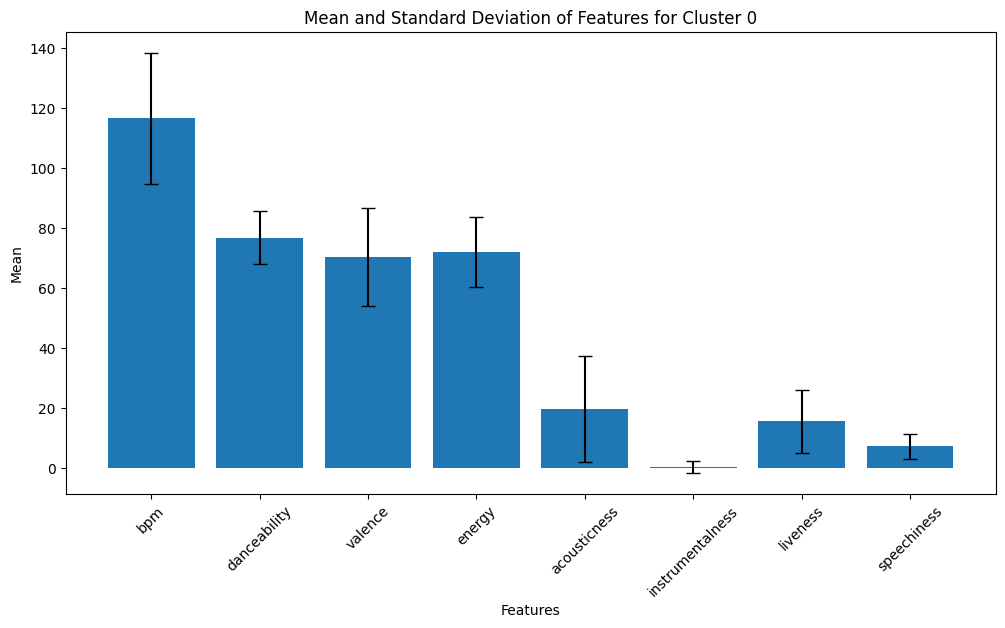

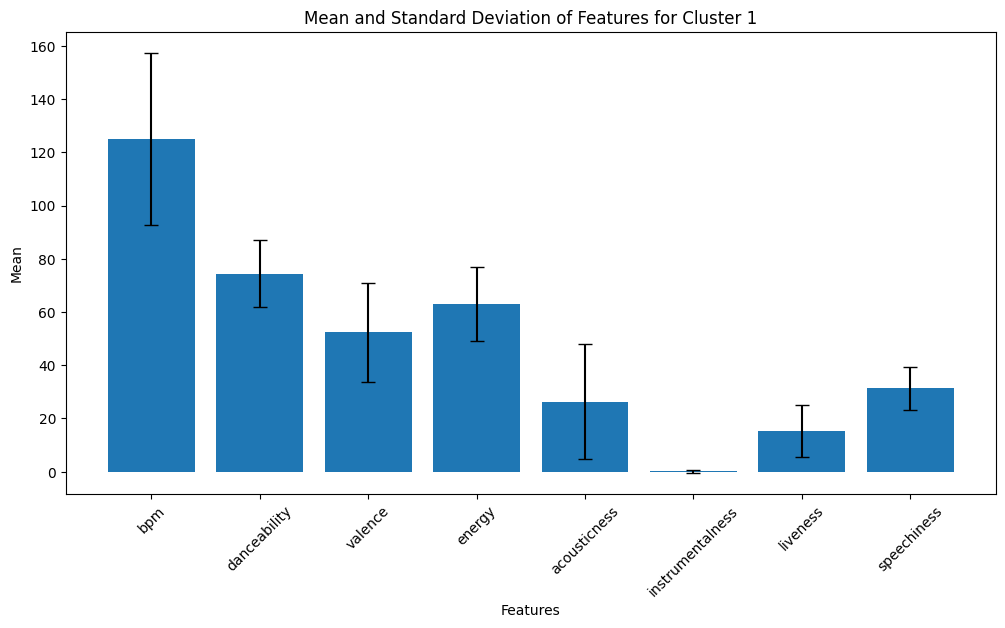

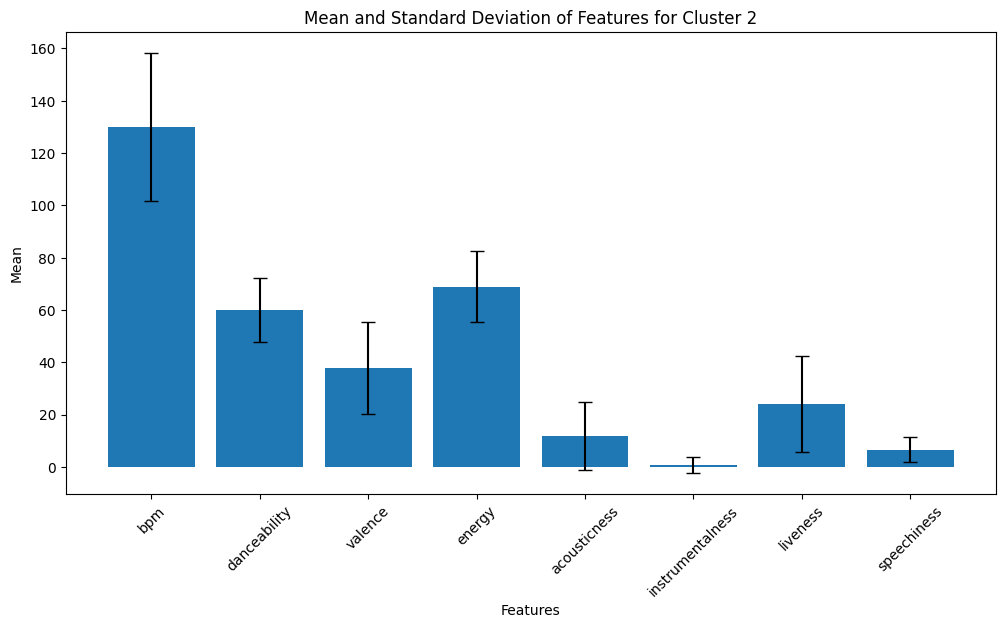

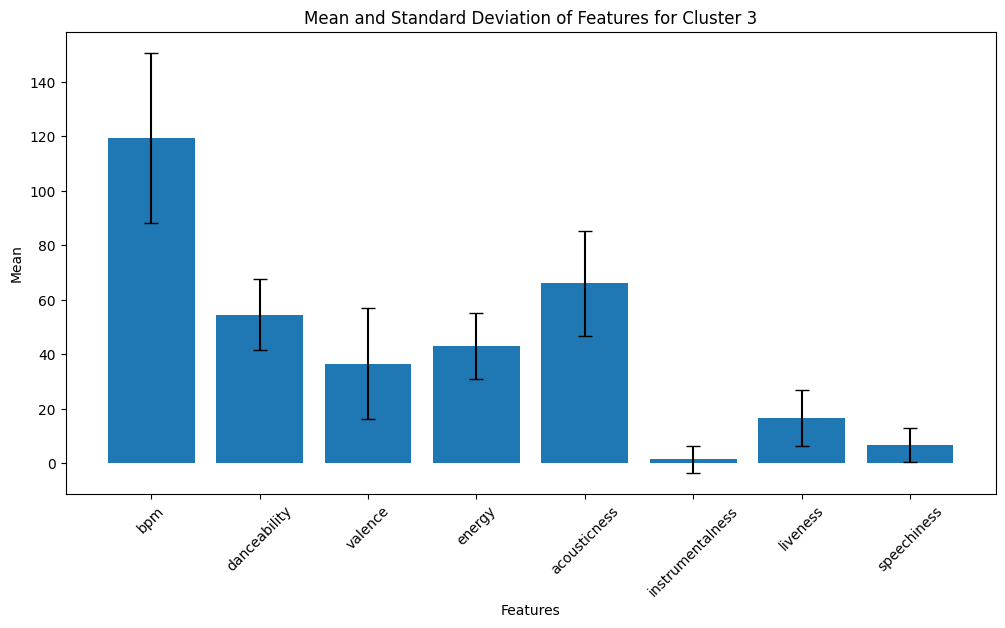

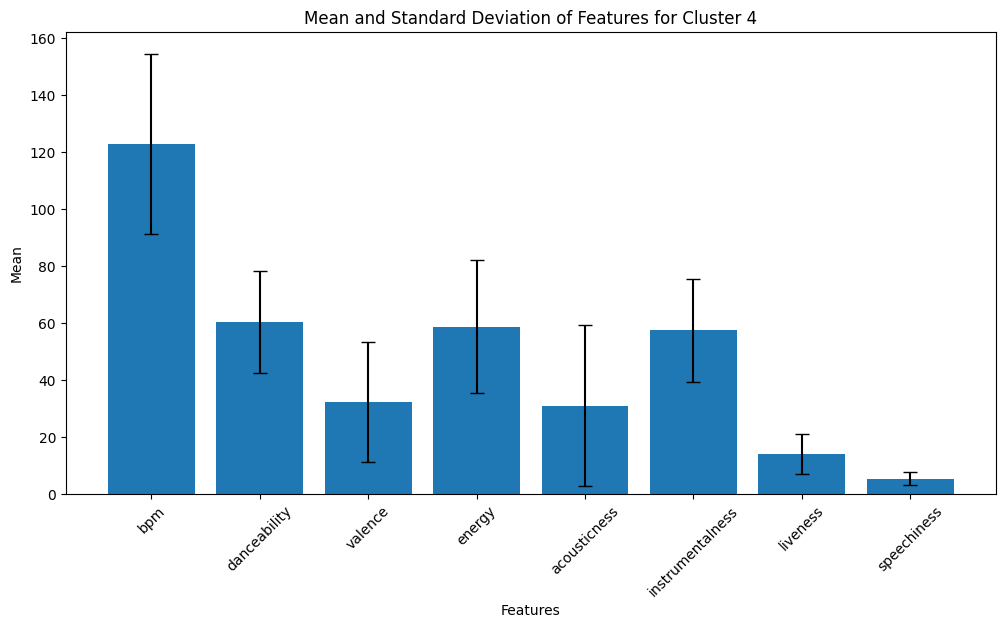

In [ ]:
# 각 클러스터별 막대 그래프 시각화
def plot_bars_for_clusters(df, features):
    clusters = sorted(df['cluster'].unique())

    for cluster in clusters:
        cluster_data = df[df['cluster'] == cluster][features]
        means = cluster_data.mean()
        stds = cluster_data.std()

        plt.figure(figsize=(12, 6))
        plt.bar(x=means.index.tolist(), height=means.values, yerr=stds.values, capsize=5)
        plt.title(f'Mean and Standard Deviation of Features for Cluster {cluster}')
        plt.xlabel('Features')
        plt.ylabel('Mean')
        plt.xticks(rotation=45)
        plt.show()

# 막대 그래프 시각화
plot_bars_for_clusters(df, features)

수치로 확인하기 어떤 음악적 특성이 두드러지게 나타나는지 확인하기 어려워서 시각화를 진행해보았고 막대그래프를 사용하고 에러바를 사용해서 표준편차도 확인할 수 있도록 하였습니다.

Cluster 0

bpm: 평균 116.55, 표준 편차 21.8 (중간)
* danceability: 평균 76.81, 표준 편차 8.69 (높음)
* valence: 평균 70.34, 표준 편차 16.35 (높음)
* energy: 평균 71.9, 표준 편차 11.69 (높음)
* acousticness: 평균 19.6, 표준 편차 17.76 (중간)
* instrumentalness: 평균 0.29, 표준 편차 1.96 (낮음)
* liveness: 평균 15.61, 표준 편차 10.51 (중간)
* speechiness: 평균 7.19, 표준 편차 4.29 (중간)

설명: danceability와 valence가 높고, energy도 높아 활기찬 곡들이 많을 것으로 예상됨

예상 장르: 팝, 댄스

Cluster 1

* bpm: 평균 125.09, 표준 편차 32.27 (중간)
* danceability: 평균 74.32, 표준 편차 12.57 (높음)
* valence: 평균 52.32, 표준 편차 18.54 (중간)
* energy: 평균 63.06, 표준 편차 13.89 (중간)
* acousticness: 평균 26.28, 표준 편차 21.52 (중간)
* instrumentalness: 평균 0.08, 표준 편차 0.57 (낮음)
* liveness: 평균 15.35, 표준 편차 9.73 (중간)
* speechiness: 평균 31.28, 표준 편차 8.0 (높음)

설명: speechiness가 높고, danceability와 bpm이 높은 경향이 있음

예상 장르: 힙합, 랩, R&B

Cluster 2

* bpm: 평균 130.04, 표준 편차 28.22 (높음)
* danceability: 평균 60.07, 표준 편차 12.16 (중간)
* valence: 평균 37.71, 표준 편차 17.68 (낮음)
* energy: 평균 68.96, 표준 편차 13.42 (높음)
* acousticness: 평균 11.84, 표준 편차 12.91 (낮음)
* instrumentalness: 평균 0.69, 표준 편차 3.04 (낮음)
* liveness: 평균 24.02, 표준 편차 18.42 (높음)
* speechiness: 평균 6.62, 표준 편차 4.7 (중간)

설명: bpm과 energy가 높고, acousticness가 낮음

예상 장르: 일렉트로닉, 록

Cluster 3

* bpm: 평균 119.4, 표준 편차 31.16 (중간)
* danceability: 평균 54.49, 표준 편차 12.92 (중간)
* valence: 평균 36.55, 표준 편차 20.4 (낮음)
* energy: 평균 42.93, 표준 편차 12.07 (낮음)
* acousticness: 평균 65.94, 표준 편차 19.1 (높음)
* instrumentalness: 평균 1.35, 표준 편차 4.95 (중간)
* liveness: 평균 16.44, 표준 편차 10.34 (중간)
* speechiness: 평균 6.7, 표준 편차 6.11 (중간)

설명: acousticness가 높고, energy와 valence가 낮음

예상 장르: 어쿠스틱, 인디

Cluster 4

* bpm: 평균 122.76, 표준 편차 31.61 (중간)
* danceability: 평균 60.35, 표준 편차 17.84 (중간)
* valence: 평균 32.24, 표준 편차 20.98 (낮음)
* energy: 평균 58.65, 표준 편차 23.36 (중간)
* acousticness: 평균 31.0, 표준 편차 28.22 (중간)
* instrumentalness: 평균 57.41, 표준 편차 18.15 (높음)
* liveness: 평균 14.12, 표준 편차 6.95 (중간)
* speechiness: 평균 5.41, 표준 편차 2.43 (낮음)

설명: instrumentalness가 매우 높고, valence가 낮음

예상 장르: 클래식, 재즈


---


Cluster 0: 예상 장르: 팝, 댄스

Cluster 1: 예상 장르: 힙합, 랩

Cluster 2: 예상 장르: 일렉트로닉, 록

Cluster 3: 어쿠스틱, 인디

Cluster 4: 클래식, 재즈



### 아티스트 음악성 유사도 네트워크 그래프

---



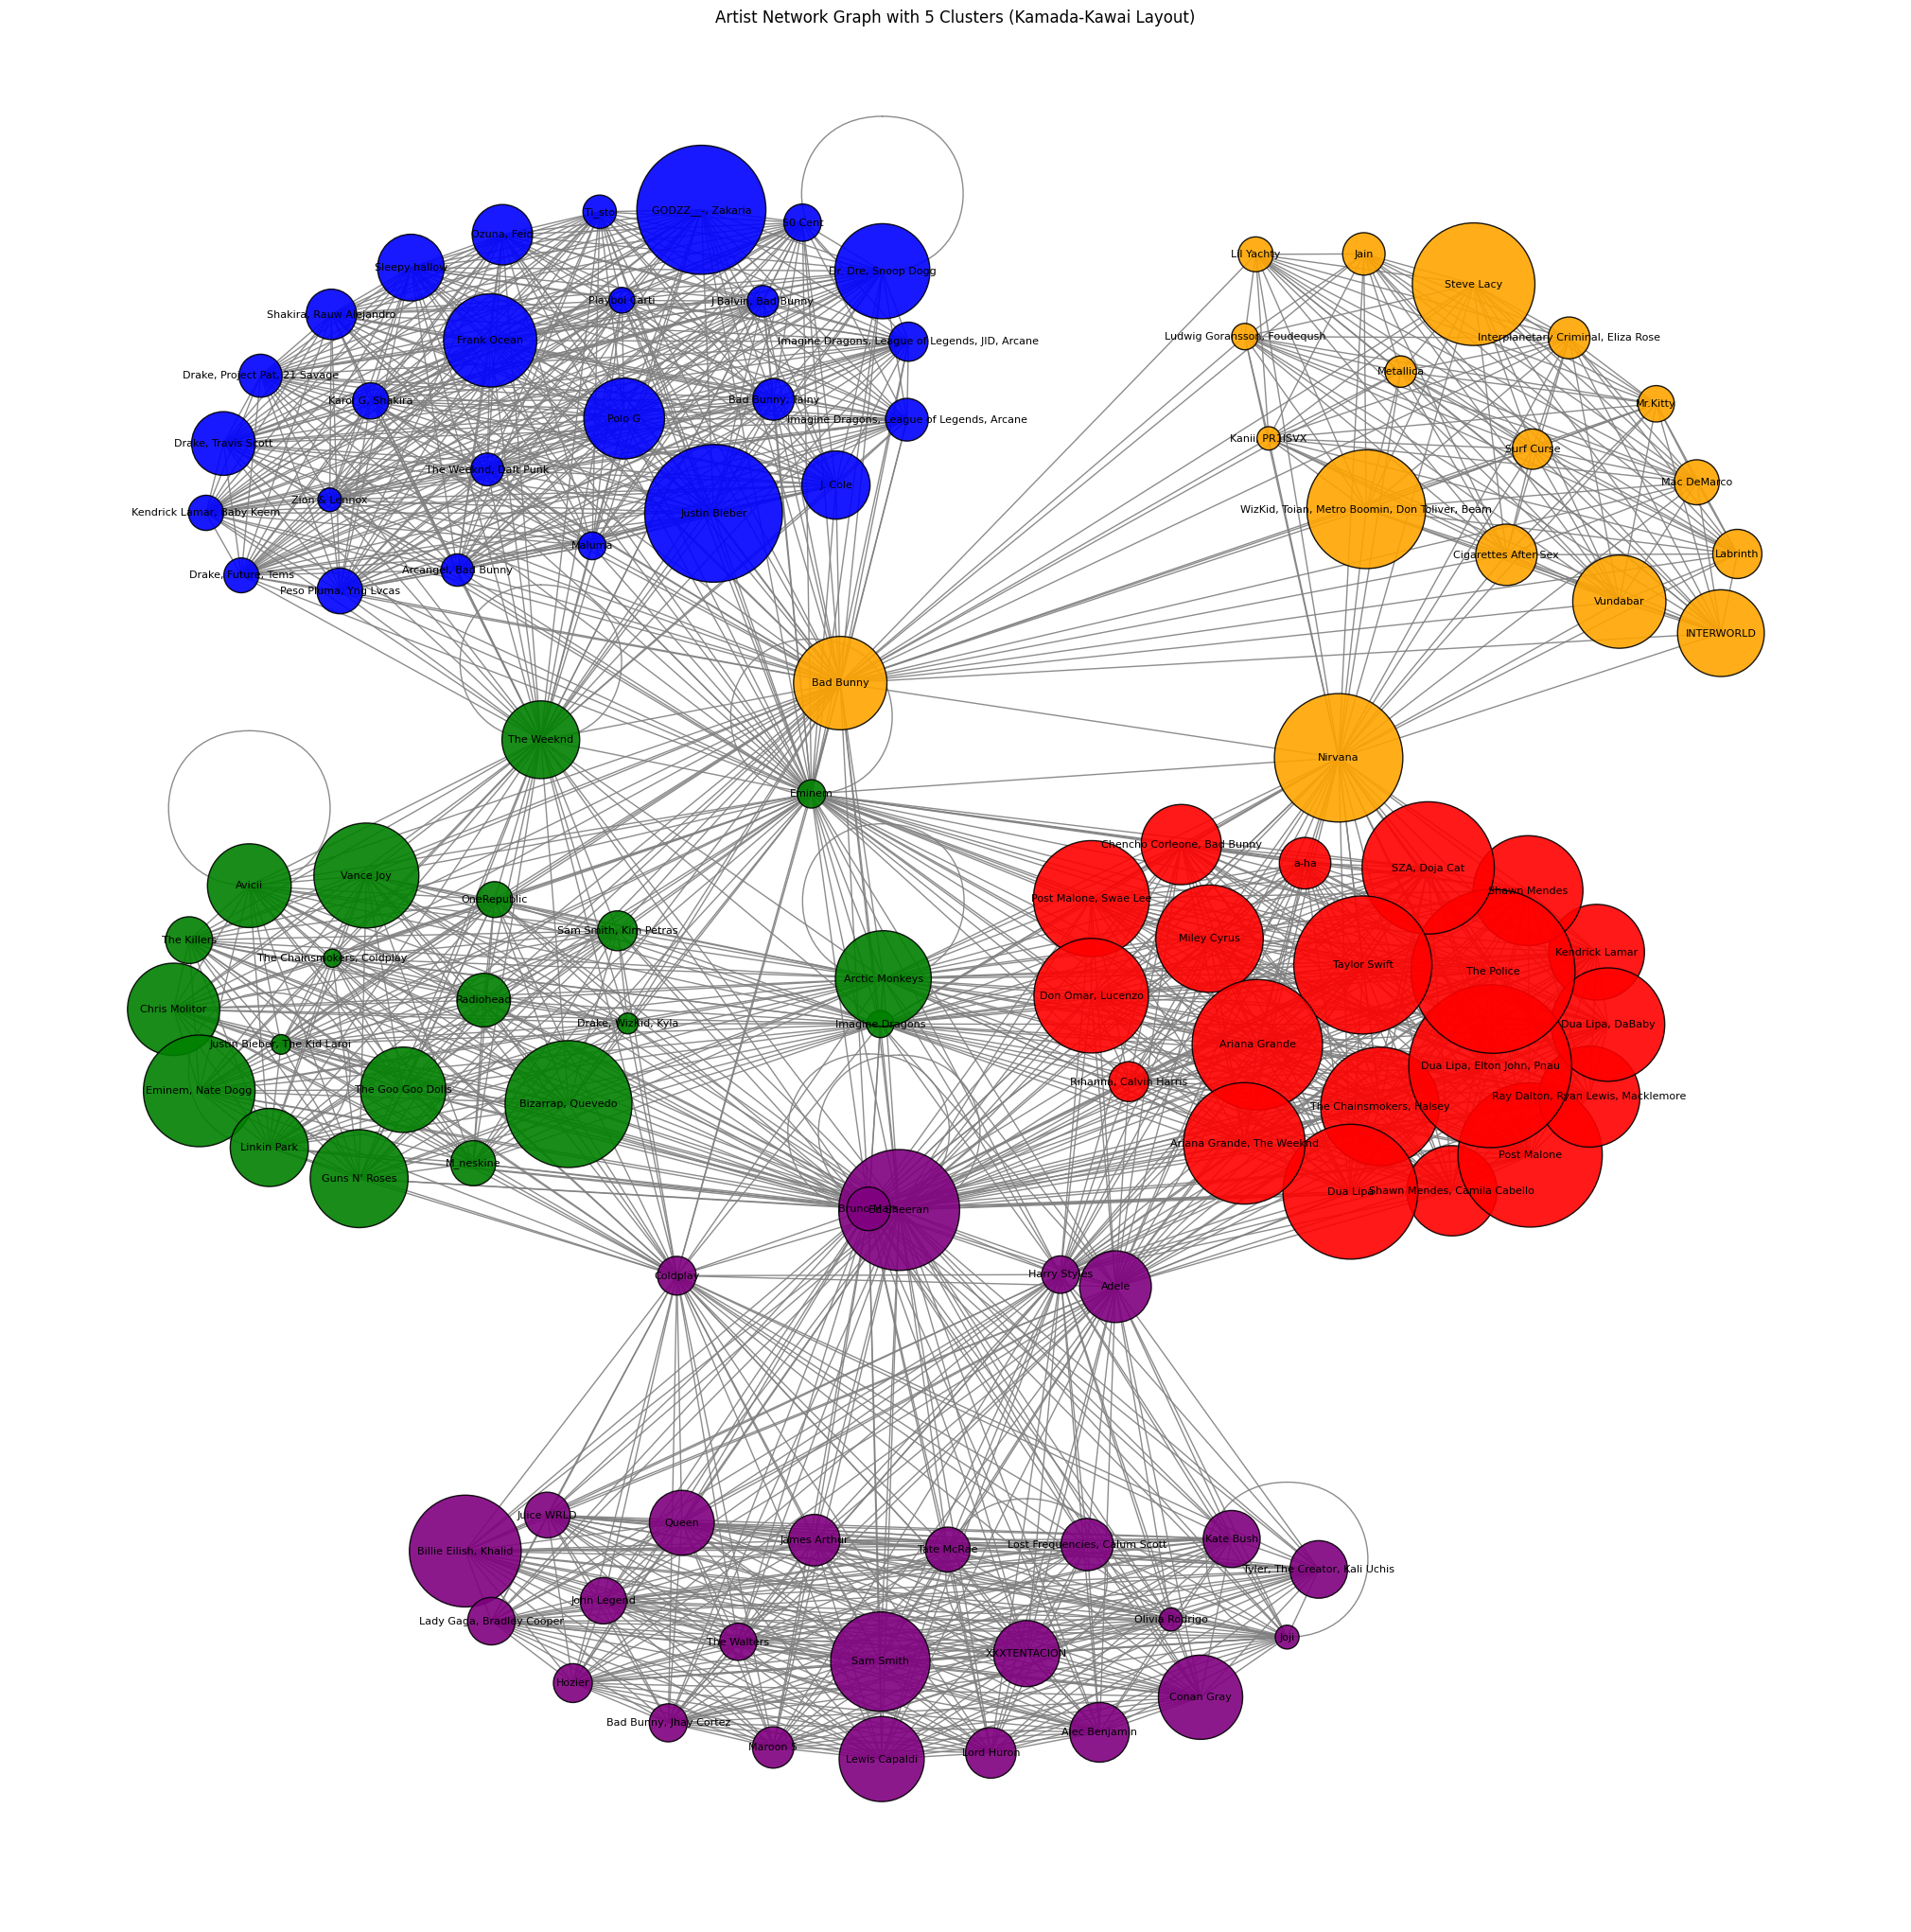

In [ ]:
artist_weight = df['streams']

# 네트워크 그래프 생성
G = nx.Graph()

# 각 클러스터에서 상위 50명의 아티스트만 선택
top_artists = df.groupby('cluster').apply(lambda x: x.nlargest(30, 'streams', keep='all')).reset_index(drop=True)

# 아티스트 노드 추가
for artist, weight, cluster in zip(top_artists['artists_name'], artist_weight[top_artists.index], top_artists['cluster']):
    G.add_node(artist, size=weight, cluster=cluster)

# 에지 추가 (같은 클러스터에 있는 아티스트끼리 하나의 에지로 연결)
for cluster in top_artists['cluster'].unique():
    cluster_artists = top_artists[top_artists['cluster'] == cluster]['artists_name']
    for i, artist1 in enumerate(cluster_artists):
        for artist2 in cluster_artists[i + 1:]:
            G.add_edge(artist1, artist2)

# 노드 색상 설정 (클러스터별로 다른 색상)
color_map = {0: 'red', 1: 'blue', 2: 'green', 3: 'purple', 4: 'orange'}
node_colors = [color_map[G.nodes[node]['cluster']] for node in G.nodes]

# 노드 크기 설정
node_sizes = [G.nodes[node]['size'] * 0.000006 for node in G.nodes]  # 크기 조정용 상수입니다.

# 각 클러스터별 상위 50개 아티스트 이름만 표시
labels = {artist: artist for artist in top_artists['artists_name']}

# 네트워크 그래프 시각화
plt.figure(figsize=(20, 20))

# Kamada-Kawai 레이아웃 적용
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, node_color=node_colors, node_size=node_sizes, with_labels=False, edge_color='gray', alpha=0.9, linewidths=1, edgecolors='black')

# 노드 중앙에 레이블 추가
for artist, (x, y) in pos.items():
    plt.text(x, y, artist, fontsize=8, ha='center', va='center')

plt.title('Artist Network Graph with 5 Clusters (Kamada-Kawai Layout)')
plt.show()

예측된 장르를 바탕으로 음악성이 비슷한 아티스트 간의 네트워크 그래프를 구성하여 다양한 장르를 아우르는 아티스트들을 확인할 수 있었습니다.

### 클러스터별 스트리밍 수에 영향을 미치는 요인 분석

---

*   다중 회귀 분석

스트리밍 수에 영향을 주는 음악적 특성이 있을 것이라는 가설을 바탕으로 다중 회귀 분석 모델을 적용해보았습니다.
다중 회귀 분석은 여러 독립 변수가 종속 변수에 미치는 영향을 평가하기 위한 기본적인 분석 방법으로 사용됩니다. 음악적 특성을 독립변수로 스트리밍 수를 종속 변수로 두고 분석을 진행해하였습니다.

#### 다중 회귀 분석

---



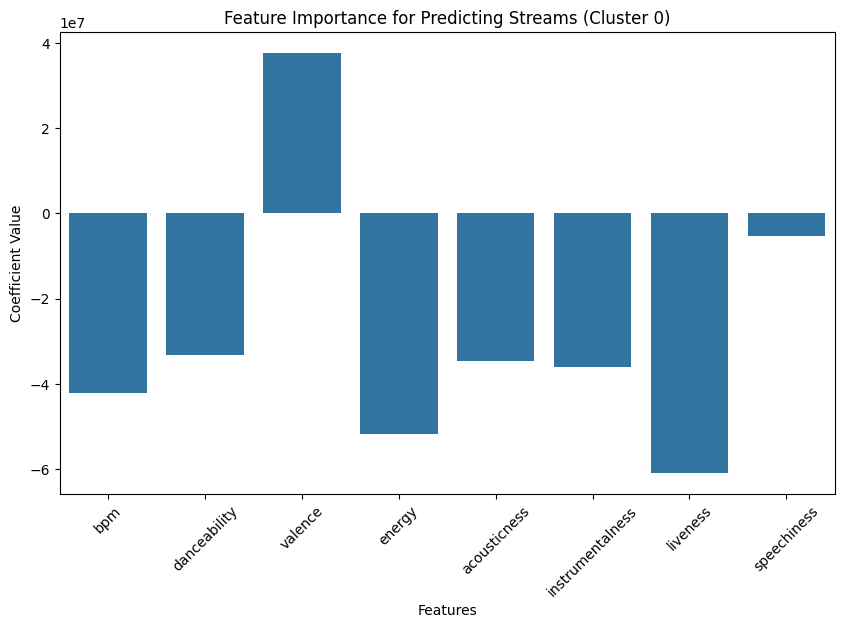

Cluster 0 Summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     1.595
Date:                Wed, 19 Jun 2024   Prob (F-statistic):              0.125
Time:                        04:48:33   Log-Likelihood:                -7043.2
No. Observations:                 328   AIC:                         1.410e+04
Df Residuals:                     319   BIC:                         1.414e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.771e+08   2.87e+07 

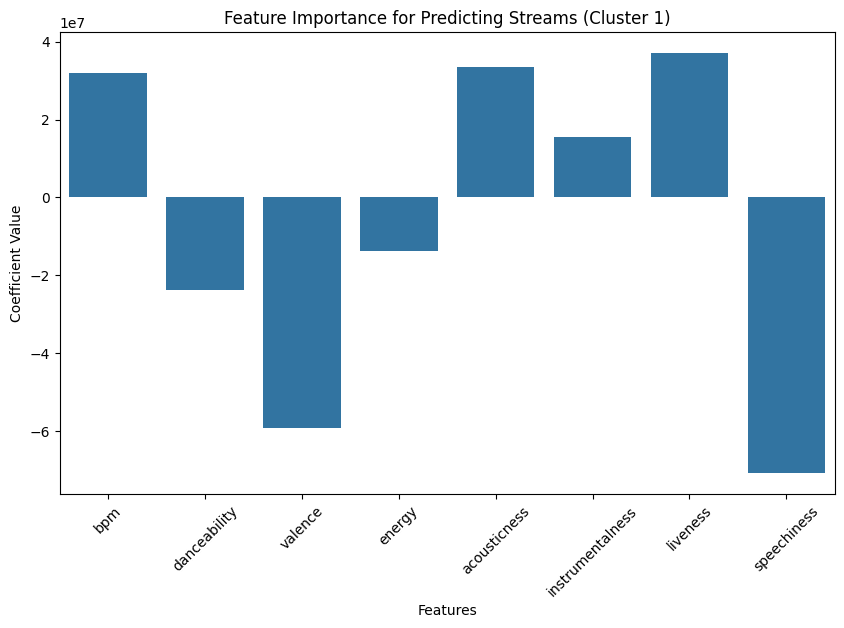

Cluster 1 Summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.8209
Date:                Wed, 19 Jun 2024   Prob (F-statistic):              0.586
Time:                        04:48:34   Log-Likelihood:                -2700.6
No. Observations:                 127   AIC:                             5419.
Df Residuals:                     118   BIC:                             5445.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        3.76e+08   3.83e+07 

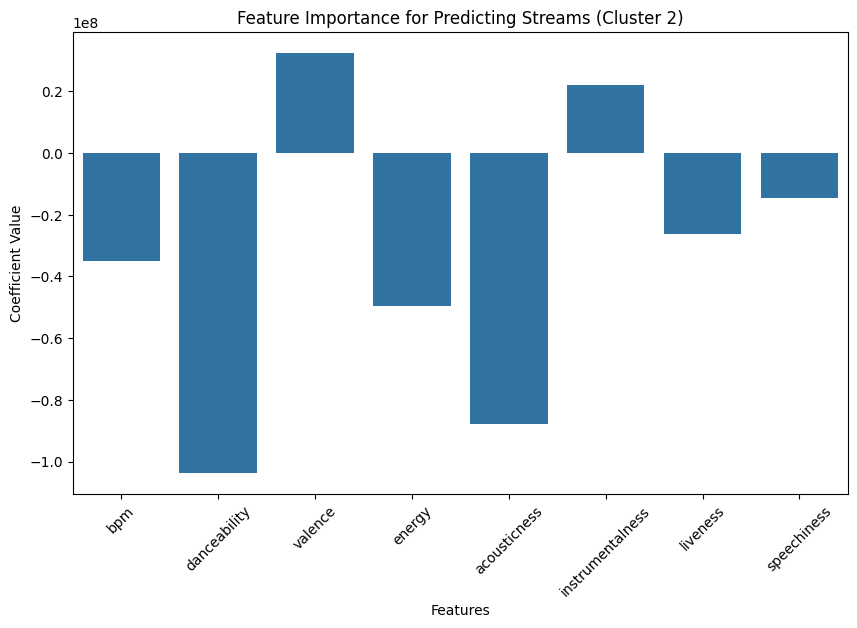

Cluster 2 Summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     2.511
Date:                Wed, 19 Jun 2024   Prob (F-statistic):             0.0121
Time:                        04:48:34   Log-Likelihood:                -5754.6
No. Observations:                 268   AIC:                         1.153e+04
Df Residuals:                     259   BIC:                         1.156e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.791e+08   3.18e+07 

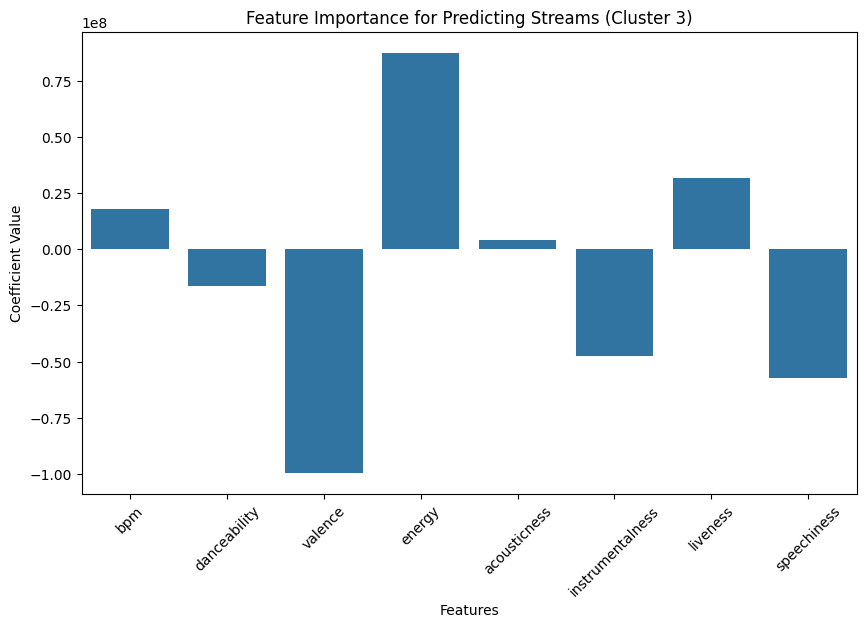

Cluster 3 Summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     1.315
Date:                Wed, 19 Jun 2024   Prob (F-statistic):              0.240
Time:                        04:48:35   Log-Likelihood:                -3489.8
No. Observations:                 162   AIC:                             6998.
Df Residuals:                     153   BIC:                             7025.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.232e+08   4.44e+07 

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


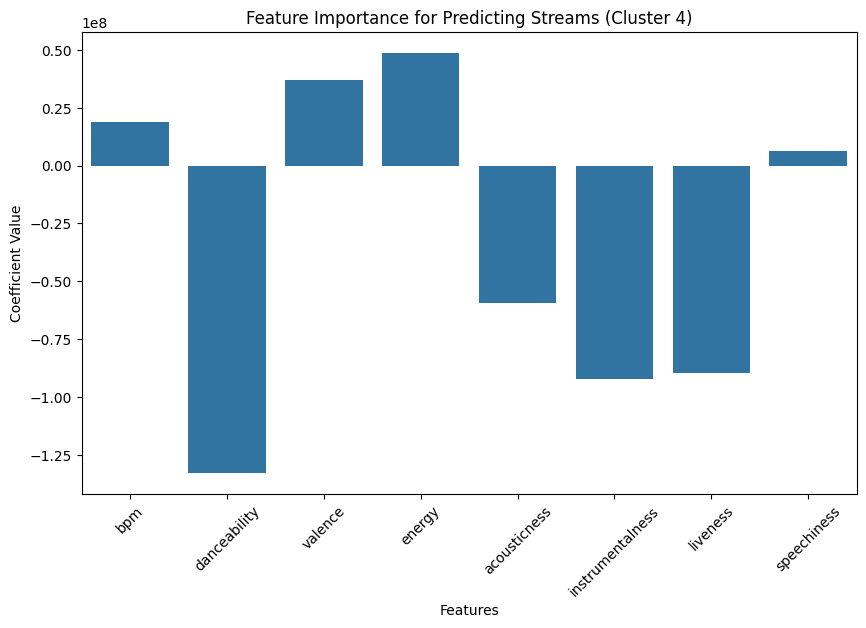

Cluster 4 Summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     2.102
Date:                Wed, 19 Jun 2024   Prob (F-statistic):              0.157
Time:                        04:48:35   Log-Likelihood:                -343.31
No. Observations:                  17   AIC:                             704.6
Df Residuals:                       8   BIC:                             712.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.443e+08   5.04e+07 

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [ ]:
# 각 클러스터별 회귀 분석 수행
def regression_analysis_for_clusters(df, features, target):
    clusters = df['cluster'].unique()
    results_summary = {}

    for cluster in sorted(clusters):
        cluster_df = df[df['cluster'] == cluster]

        X = cluster_df[features]
        y = cluster_df[target]

        # 특성 스케일 조정
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # numpy 배열로 변환하고 float 형식으로 변환
        X_scaled_np = np.asarray(X_scaled).astype(np.float64)
        y_np = np.asarray(y).astype(np.float64)

        # 선형 회귀 모델 적합
        model = LinearRegression()
        model.fit(X_scaled_np, y_np)

        # 계수 얻기
        coefficients = pd.DataFrame(model.coef_, features, columns=['Coefficient'])

        # statsmodels를 사용하여 통계 분석 수행
        X_with_const = sm.add_constant(X_scaled_np)
        model_sm = sm.OLS(y_np, X_with_const)
        results = model_sm.fit()

        # 결과 요약 저장
        results_summary[cluster] = {
            "summary": results.summary(),
            "coefficients": coefficients
        }

        # 계수 그래프화
        plt.figure(figsize=(10, 6))
        sns.barplot(x=coefficients.index, y=coefficients['Coefficient'])
        plt.title(f'Feature Importance for Predicting Streams (Cluster {cluster})')
        plt.xlabel('Features')
        plt.ylabel('Coefficient Value')
        plt.xticks(rotation=45)
        plt.show()

        # 요약 출력
        print(f"Cluster {cluster} Summary:")
        print(results.summary())
        print("\n")

    return results_summary

# 각 클러스터에 대해 회귀 분석 수행
results_summary = regression_analysis_for_clusters(df, features, 'streams')

모든 장르에 대해서 각각의 분석 수치 값을 통해 음악적 특성들은 일부 영향이 있을 수 있지만 스트리밍 수에 크게 유의미한 영향을 주지 않는다는 결과를 확인할 수 있었습니다.

### 클러스터별 곡 수 & 스트리밍 평균

---



In [ ]:
# 각 클러스터별 곡수 계산
cluster_counts = df['cluster'].value_counts().sort_index()

cluster_counts_df = cluster_counts.reset_index()
cluster_streams_mean_df = cluster_streams_mean.reset_index()

# 각 클러스터별 스트리밍 수 평균 계산
cluster_streams_mean = df.groupby('cluster')['streams'].mean().round(2)

# 두 결과를 하나의 데이터프레임으로 결합
cluster_count_mean = pd.DataFrame({
    'cluster': cluster_counts.index,
    'count': cluster_counts.values,
    'streams_mean': cluster_streams_mean.values
})

# 결과 출력
cluster_count_mean

cluster  count  streams_mean
0        0    328  477146037.83
1        1    127  375968350.78
2        2    268  479054345.08
3        3    162  523183605.56
4        4     17  344317106.47

### 클러스터별 곡 수 & 스트리밍 평균 시각화

---



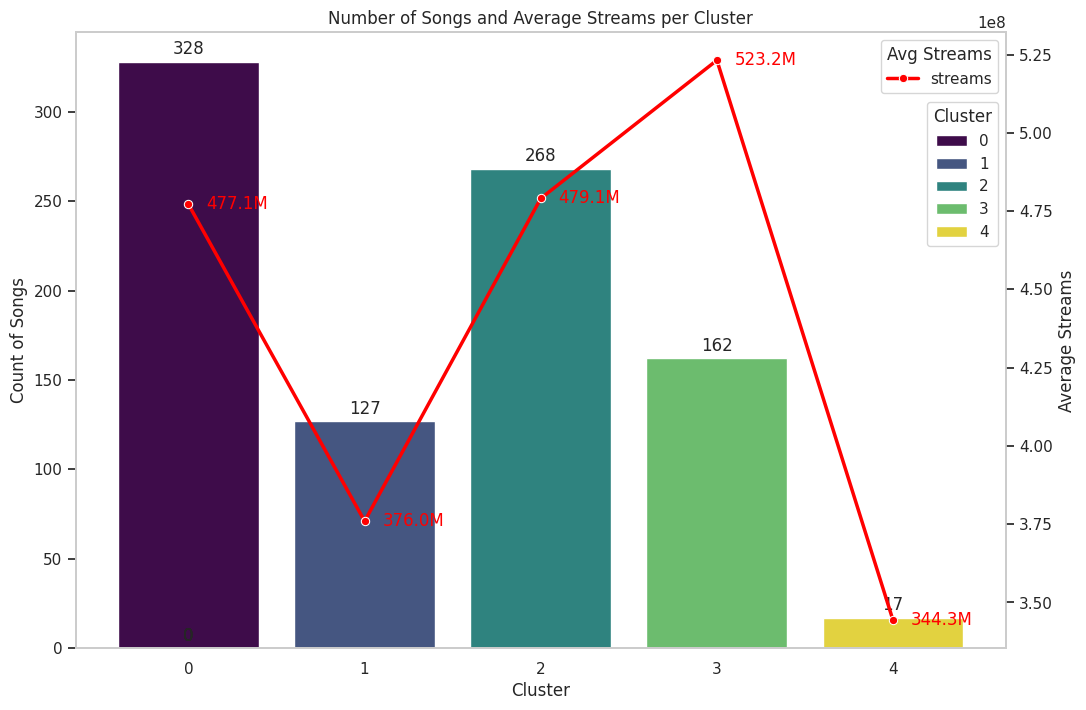

In [ ]:
# 각 클러스터별 스트리밍 수 계산
cluster_streams_mean = df.groupby('cluster')['streams'].mean().round(2).reset_index()

# 스타일 설정
sns.set(style="whitegrid")

fig, ax1 = plt.subplots(figsize=(12, 8))

# 첫 번째 y축: 곡수
barplot = sns.barplot(x='cluster', y='count', data=cluster_counts_df, palette='viridis', hue='cluster', dodge=False, ax=ax1)
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Count of Songs')
ax1.set_title('Number of Songs and Average Streams per Cluster')

# 수치값
for p in barplot.patches:
    ax1.annotate(format(p.get_height(), '.0f'),
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center',
                 xytext=(0, 9),
                 textcoords='offset points')

# 두 번째 y축: 스트리밍 수
ax2 = ax1.twinx()
ax2.set_ylabel('Average Streams')
lineplot = sns.lineplot(x='cluster', y='streams', data=cluster_streams_mean, color='red', marker='o', ax=ax2, linewidth=2.5, label='streams')

# 스트리밍 수치
for i in range(len(cluster_streams_mean)):
    streams_value = cluster_streams_mean.loc[i, 'streams']
    if streams_value >= 1e9:
        formatted_value = f"{streams_value / 1e9:.1f}B"
    else:
        formatted_value = f"{streams_value / 1e6:.1f}M"
    ax2.text(i, streams_value, formatted_value, color='red', ha='left', va='center', position=(i + 0.1, streams_value))

# y축 가로선 제거
ax1.yaxis.grid(False)
ax2.yaxis.grid(False)

# 범례 추가
ax1.legend(title='Cluster', bbox_to_anchor=(1.0, 0.77), loc='center right')
ax2.legend(title='Avg Streams', loc='upper right')

plt.show()

비교적 곡수와 스트리밍 수가 비례하는 모습을 보이고 있지만 3번 클러스터, 어쿠스틱, 인디 장르에서 포함된 곡 수에 비해 가장 높은 스트리밍 평균 값을 나타내는 것을 확인하였습니다.

## 아티스트별 스트리밍 수 분석

---
위 내용을 바탕으로 장르별로 어떤 아티스트가 인기 있는지에 대해서 인기 있는 특정 아티스트 곡의 스트리밍 수가 높을 것이라는 가설을 세우고 다음 분석을 진행해보았습니다.

In [ ]:
# 각 클러스터별로 상위 아티스트를 확인하는 코드
top_artists_per_cluster = df.groupby('cluster')['artists_name'].apply(lambda x: x.value_counts().head(10)).reset_index()
top_artists_per_cluster.columns = ['cluster', 'artists_name', 'count']

# 결과를 확인
top_artists_per_cluster

cluster                         artists_name  count
0         0                            Bad Bunny     11
1         0                         Harry Styles      5
2         0                             NewJeans      5
3         0                                 Feid      4
4         0                         Taylor Swift      4
5         0                                  SZA      3
6         0                             Dua Lipa      3
7         0                                Lizzo      3
8         0                           The Weeknd      3
9         0                        Morgan Wallen      3
10        1                       Kendrick Lamar      4
11        1                     Drake, 21 Savage      4
12        1                            Bad Bunny      3
13        1                             Lil Baby      2
14        1                             Doja Cat      2
15        1                  Dr. Dre, Snoop Dogg      2
16        1                           Stray Kids      2
17        1                          Central Cee      2
18        1                               Future      2
19        1                              Karol G      2
20        2                         Taylor Swift     16
21        2                           The Weeknd      9
22        2                        Morgan Wallen      8
23        2                                  SZA      6
24        2                     Drake, 21 Savage      4
25        2                                  BTS      4
26        2                         Harry Styles      3
27        2                            Bad Bunny      3
28        2                                 Feid      3
29        2                                Drake      3
30        3                         Taylor Swift     13
31        3                                  SZA      9
32        3                         Harry Styles      6
33        3                             Labrinth      5
34        3                           The Weeknd      5
35        3                       Kendrick Lamar      5
36        3                                 Joji      3
37        3                       Olivia Rodrigo      3
38        3                        Billie Eilish      3
39        3                           Bruno Mars      2
40        4                 Cigarettes After Sex      1
41        4                             Mr.Kitty      1
42        4          Ludwig Goransson, Foudeqush      1
43        4  Interplanetary Criminal, Eliza Rose      1
44        4                       Kanii, PR1ISVX      1
45        4                           INTERWORLD      1
46        4                             Labrinth      1
47        4                              Nirvana      1
48        4                           Steve Lacy      1
49        4                            Metallica      1

In [ ]:
# 각 클러스터별로 스트리밍 수가 많은 아티스트를 확인하는 코드
top_streamed_artists_per_cluster = df.groupby(['cluster', 'artists_name'])['streams'].sum().reset_index()

# 각 클러스터별 상위 10명의 아티스트를 선정
top_streamed_artists_per_cluster = top_streamed_artists_per_cluster.sort_values(['cluster', 'streams'], ascending=[True, False]).groupby('cluster').head(10).reset_index(drop=True)

# 결과를 확인
top_streamed_artists_per_cluster

cluster                                     artists_name     streams
0         0                                       Ed Sheeran  6038686605
1         0                                        Bad Bunny  4747704793
2         0                                  Imagine Dragons  3432120033
3         0                                         Dua Lipa  3227639000
4         0                                           Eminem  3112253595
5         0                            Post Malone, Swae Lee  2808096550
6         0                                     Harry Styles  2759412834
7         0                                     Taylor Swift  2703315786
8         0                         The Chainsmokers, Halsey  2591224264
9         0                     Shawn Mendes, Camila Cabello  2484812918
10        1                            The Weeknd, Daft Punk  2565529693
11        1                                    Justin Bieber  2123309722
12        1                              Dr. Dre, Snoop Dogg  2053908531
13        1                                        Bad Bunny  1938221266
14        1                                          J. Cole  1791000570
15        1                              J Balvin, Bad Bunny  1435127549
16        1                                 Bad Bunny, Tainy  1304313953
17        1                                           Eminem  1241559043
18        1       Imagine Dragons, League of Legends, Arcane  1223481149
19        1  Imagine Dragons, League of Legends, JID, Arcane  1223481149
20        2                                       The Weeknd  7846495359
21        2                                     Taylor Swift  5909590438
22        2                                   Arctic Monkeys  4302473381
23        2                                           Avicii  3426754746
24        2                                      Linkin Park  2985590613
25        2                                              SZA  2828030753
26        2                                       Ed Sheeran  2775897475
27        2                                        Bad Bunny  2725304965
28        2                              Drake, WizKid, Kyla  2713922350
29        2                     Justin Bieber, The Kid Laroi  2665343922
30        3                                     Taylor Swift  5187101226
31        3                                   Olivia Rodrigo  2891195592
32        3                                       Bruno Mars  2724143947
33        3                                     James Arthur  2420461338
34        3                                             Joji  2357270185
35        3                            Billie Eilish, Khalid  2355719893
36        3                                     Harry Styles  2324171663
37        3                                       Juice WRLD  2288695111
38        3                                       Ed Sheeran  2236667932
39        3                                         Coldplay  2232266269
40        4                             Cigarettes After Sex   841749534
41        4                                       Surf Curse   824420218
42        4                                        Metallica   704171068
43        4                                         Mr.Kitty   646886885
44        4                                         Vundabar   370068639
45        4                                          Nirvana   368646862
46        4                                       INTERWORLD   357580552
47        4                                        Bad Bunny   303236322
48        4                                         Labrinth   282883169
49        4                                      Mac DeMarco   244658767

In [ ]:
import plotly.express as px

# 데이터프레임 준비
top_streamed_artists_per_cluster = df.groupby(['cluster', 'artists_name'])['streams'].sum().reset_index()
top_streamed_artists_per_cluster = top_streamed_artists_per_cluster.sort_values(['cluster', 'streams'], ascending=[True, False]).groupby('cluster').head(10).reset_index(drop=True)

# tree map 생성
fig = px.treemap(top_streamed_artists_per_cluster,
                 path=['cluster', 'artists_name'],
                 values='streams',
                 title='Top 10 Streamed Artists per Cluster')

# 시각화 표시
fig.show()

Tree map을 사용해 장르별로 아티스트 스트리밍 수를 나타내보았는데 보이는 것과 같이 일반적으로 알고 있는 인기 유명 가수들이 대부분을 차지하고 있는 것을 알 수 있었습니다.

### 아티스트 곡 수와 스트리밍 수에 대한 분석

---

아티스트가 발매한 곡수와 스트리밍 수에 대해 영향이 있을 것이라는 가설을 세우고 이에 대해 분석을 진행하였습니다.

In [ ]:
# Calculate the number of tracks and total streams for each artist, then sort by total streams in descending order
artist_stats_sorted = df.groupby('artists_name').agg(
    track_count=('track_name', 'count'),
    total_streams=('streams', 'sum')
).reset_index().sort_values(by='total_streams', ascending=False).reset_index(drop=True)

# Display the dataframe
artist_stats_sorted

artists_name  track_count  \
0                                         Taylor Swift           34   
1                                           Ed Sheeran            7   
2                                            Bad Bunny           19   
3                                           The Weeknd           19   
4                                         Harry Styles           15   
..                                                 ...          ...   
611                                        Offset, JID            1   
612                                Mc Pedrinho, DJ 900            1   
613                       Sog, Ryan Castro, Peso Pluma            1   
614  Arijit Singh, Vishal Dadlani, Sukriti Kakar, V...            1   
615                         Carin Leon, Grupo Frontera            1   

     total_streams  
0      14053658300  
1      11051252012  
2       9997799607  
3       9815205161  
4       6772877034  
..             ...  
611       24975653  
612       11956641  
613       11599388  
614        1365184  
615           2762  

[616 rows x 3 columns]

In [ ]:
# Get the top 100 artists by total streams
top_100_artists = artist_stats_sorted.head(100)

# Create a treemap using Plotly with a 4:3 aspect ratio
fig = px.treemap(
    top_100_artists,
    path=['artists_name'],
    values='total_streams',
    title='Top 100 Artists by Total Streams',
    color='track_count',
    color_continuous_scale='Blues',
    labels={'total_streams': 'Total Streams', 'track_count': 'Track Count'},
    width=1500,
    height=1000
)

# Show the plot
fig.show()

사각형의 크기가 스트리밍 수를 나타내고 오른편의 범례를 참고로 색이 발매 곡수를 나타내고 있습니다.

Top 10을 제외하고는 발매곡수가 큰차이를 보이지 않지만 특정 아티스트가 스트리밍 수가 압도적으로 높은 것을 알 수 있고 곡 수가 스트리밍 수에 영향을 준다고 판단할 수 있습니다.

## 피처링 관련 분석

---



In [ ]:
# 피처링된 곡 여부를 판단하는 함수 정의
def is_featuring(track_name):
    return any(feat in track_name.lower() for feat in ['feat.', '(w', '[w'])

# 새로운 컬럼 'is_featuring' 추가
df['is_featuring'] = df['track_name'].apply(is_featuring)

# 각 클러스터별 피처링된 곡의 수 계산
cluster_featuring_counts = df[df['is_featuring']].groupby('cluster').size()

# 결과 출력
print(cluster_featuring_counts)

cluster
0    34
1    21
2    25
3    11
4     1
dtype: int64


In [ ]:
# 피처링된 곡 중 피처링한 가수 이름으로 필터링
featuring_df = df[df['is_featuring']]

# 각 클러스터별 피처링된 곡의 스트리밍 수와 피처링 아티스트 이름을 시리즈 형태로 저장
cluster_featuring_streams_artists = featuring_df.groupby('cluster')[['featuring_artists', 'streams']].apply(
    lambda x: x.reset_index(drop=True)
).reset_index(level=0)

# 각 클러스터별로 스트리밍 수를 내림차순으로 정렬하여 출력
clusters = cluster_featuring_streams_artists['cluster'].unique()

for cluster in clusters:
    cluster_df = cluster_featuring_streams_artists[cluster_featuring_streams_artists['cluster'] == cluster].sort_values(by='streams', ascending=False)
    print(f"Cluster {cluster}:\n", cluster_df, "\n")

KeyError: "Columns not found: 'featuring_artists'"

In [ ]:
# 피처링된 곡 여부를 판단하는 함수 정의
def is_featuring(track_name):
    return any(feat in track_name.lower() for feat in ['feat.', '(with', '[with'])

# 피처링된 아티스트 이름을 추출하는 함수 정의
def extract_featuring_artists(track_name):
    track_name = track_name.lower()
    feat_patterns = [r'feat\. ([^()]+)', r'\(with ([^()]+)\)', r'\[with ([^]]+)\]']
    for pattern in feat_patterns:
        match = re.search(pattern, track_name)
        if match:
            return match.group(1)
    return None

# 새로운 컬럼 'is_featuring' 및 'featuring_artists' 추가
df['is_featuring'] = df['track_name'].apply(is_featuring)
df['featuring_artists'] = df['track_name'].apply(extract_featuring_artists)

# 피처링된 곡 중 피처링한 가수 이름으로 필터링
featuring_df = df[df['is_featuring']]

# 각 클러스터별 피처링된 곡의 스트리밍 수와 피처링 아티스트 이름을 시리즈 형태로 저장
cluster_featuring_streams_artists = featuring_df.groupby('cluster')[['featuring_artists', 'streams']].apply(
    lambda x: x.reset_index(drop=True)
).reset_index(level=0)

# 각 클러스터별로 스트리밍 수를 내림차순으로 정렬하여 출력
clusters = cluster_featuring_streams_artists['cluster'].unique()

for cluster in clusters:
    cluster_df = cluster_featuring_streams_artists[cluster_featuring_streams_artists['cluster'] == cluster].sort_values(by='streams', ascending=False)
    print(f"Cluster {cluster}:\n", cluster_df, "\n")

# Plotly Treemap 시각화 (전체 데이터)
for cluster in clusters:
    cluster_df = cluster_featuring_streams_artists[cluster_featuring_streams_artists['cluster'] == cluster]
    fig = px.treemap(cluster_df,
                     path=['featuring_artists'],
                     values='streams',
                     title=f'Cluster {cluster} - Streaming Counts')
    fig.update_layout(width=600, height=450, margin=dict(l=10, r=10, t=30, b=10))
    fig.update_traces(textinfo='label+percent entry')
    fig.show()

In [ ]:
# 각 클러스터별 피처링된 곡의 스트리밍 수와 피처링 아티스트 이름을 시리즈 형태로 저장
cluster_featuring_streams_artists = featuring_df.groupby('cluster')[['featuring_artists', 'streams']].apply(
    lambda x: x.reset_index(drop=True)
).reset_index(level=0)

# 각 클러스터별로 스트리밍 수를 내림차순으로 정렬하여 top 10 출력
clusters = cluster_featuring_streams_artists['cluster'].unique()

top_10_clusters = {}
for cluster in clusters:
    cluster_df = cluster_featuring_streams_artists[cluster_featuring_streams_artists['cluster'] == cluster].sort_values(by='streams', ascending=False).head(10)
    top_10_clusters[cluster] = cluster_df
    print(f"Cluster {cluster} - Top 10:\n", cluster_df, "\n")

In [ ]:
# 피처링된 곡 여부를 판단하는 함수 정의
def is_featuring(track_name):
    return any(feat in track_name.lower() for feat in ['feat.', '(with', '[with'])

# 피처링된 아티스트 이름을 추출하는 함수 정의
def extract_featuring_artists(track_name):
    track_name = track_name.lower()
    feat_patterns = [r'feat\. ([^()]+)', r'\(with ([^()]+)\)', r'\[with ([^]]+)\]']
    for pattern in feat_patterns:
        match = re.search(pattern, track_name)
        if match:
            return match.group(1)
    return None

# 새로운 컬럼 'is_featuring' 및 'featuring_artists' 추가
df['is_featuring'] = df['track_name'].apply(is_featuring)
df['featuring_artists'] = df['track_name'].apply(extract_featuring_artists)

# 피처링된 곡 중 피처링한 가수 이름으로 필터링
featuring_df = df[df['is_featuring']]

# 각 클러스터별 피처링된 곡의 스트리밍 수와 피처링 아티스트 이름을 시리즈 형태로 저장
cluster_featuring_streams_artists = featuring_df.groupby('cluster')[['featuring_artists', 'streams']].apply(
    lambda x: x.reset_index(drop=True)
).reset_index(level=0)

# 각 클러스터별로 스트리밍 수를 내림차순으로 정렬하여 top 10 출력
clusters = cluster_featuring_streams_artists['cluster'].unique()

top_10_clusters = {}
for cluster in clusters:
    cluster_df = cluster_featuring_streams_artists[cluster_featuring_streams_artists['cluster'] == cluster].sort_values(by='streams', ascending=False).head(10)
    top_10_clusters[cluster] = cluster_df

# Plotly Treemap 시각화
for cluster in clusters:
    cluster_df = top_10_clusters[cluster]
    fig = px.treemap(cluster_df,
                     path=['featuring_artists'],
                     values='streams',
                     title=f'Cluster {cluster} - Top 10 Streaming Counts')
    fig.update_layout(width=800, height=600)  # 설정된 크기
    fig.show()

In [ ]:
# 피처링된 곡 여부를 판단하는 함수 정의
def is_featuring(track_name):
    return any(feat in track_name.lower() for feat in ['feat.', '(with', '[with'])

# 새로운 컬럼 'is_featuring' 추가
df['is_featuring'] = df['track_name'].apply(is_featuring)

# 스트리밍 수 데이터를 숫자 형식으로 변환
df['streams'] = df['streams'].astype(float)

# 피처링된 곡과 피처링되지 않은 곡의 스트리밍 수 비교
featuring_streams = df[df['is_featuring']]['streams']
non_featuring_streams = df[~df['is_featuring']]['streams']

# 기술 통계 비교
print("피처링된 곡의 스트리밍 수 평균:", featuring_streams.mean())
print("피처링되지 않은 곡의 스트리밍 수 평균:", non_featuring_streams.mean())

# t-검정
t_stat, p_value = ttest_ind(featuring_streams, non_featuring_streams)
print("t-검정 통계량:", t_stat)
print("p-값:", p_value)

# 회귀 분석
df['is_featuring_int'] = df['is_featuring'].astype(int)
X = df[['is_featuring_int']]
y = df['streams']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

# 상관 분석
correlation = df[['is_featuring_int', 'streams']].corr()
print(correlation)

# 시각화
fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot([featuring_streams, non_featuring_streams], labels=['Featuring', 'Non-Featuring'])
ax.set_title('Streaming Counts Comparison')
ax.set_ylabel('Streams')
plt.show()

기술 통계 비교
피처링된 곡의 스트리밍 수 평균: 365,295,644.47
피처링되지 않은 곡의 스트리밍 수 평균: 480,894,792.48
피처링되지 않은 곡의 평균 스트리밍 수가 피처링된 곡의 평균 스트리밍 수보다 더 높습니다.

t-검정 결과
t-검정 통계량: -2.015
p-값: 0.044
p-값이 0.05보다 작기 때문에, 두 그룹 간의 차이가 통계적으로 유의미하다고 할 수 있습니다. 이는 피처링 여부가 스트리밍 수에 영향을 미친다는 것을 의미합니다.

회귀 분석 결과
종속 변수: streams (스트리밍 수)
독립 변수: is_featuring_int (피처링 여부: 0 또는 1)
R-제곱 값: 0.004
조정된 R-제곱 값: 0.003
회귀 계수 (Coefficients)
상수항 (const): 4.809e+08
is_featuring_int: -1.156e+08
통계적 유의성 (P-값)
상수항 (const): 0.000 (유의미)
is_featuring_int: 0.044 (유의미)
해석
R-제곱 값: 0.004는 회귀 모델이 전체 스트리밍 수 변동의 약 0.4%만을 설명한다는 것을 의미합니다. 이는 모델의 설명력이 매우 낮다는 것을 의미합니다.
회귀 계수 (is_featuring_int): -1.156e+08는 피처링된 곡의 스트리밍 수가 피처링되지 않은 곡에 비해 평균적으로 약 1.156억 회 적다는 것을 의미합니다.
p-값: is_featuring_int의 p-값이 0.044로, 유의수준 0.05보다 작기 때문에 피처링 여부가 스트리밍 수에 유의미한 영향을 미친다고 할 수 있습니다.
상관 분석 결과
피처링 여부와 스트리밍 수 간의 상관 계수: -0.067016
이는 약한 음의 상관 관계를 나타내며, 피처링 여부가 스트리밍 수에 큰 영향을 미치지 않음을 의미합니다.
결론
피처링된 곡은 피처링되지 않은 곡에 비해 평균적으로 스트리밍 수가 낮습니다.
t-검정과 회귀 분석 결과 피처링 여부가 스트리밍 수에 통계적으로 유의미한 영향을 미친다고 나타났지만, 모델의 설명력(R-제곱 값)이 매우 낮아 피처링 여부가 스트리밍 수의 주요한 결정 요인이 아님을 시사합니다.
상관 분석 결과에서도 피처링 여부와 스트리밍 수 간의 상관 관계가 매우 약함을 확인할 수 있습니다.

피쳐링된 곡과 그렇지 않은 곡의 곡 수가 차이가 나기 때문에 논 피쳐링곡들의 샘플을 통해 회귀 분석과 t-검정을 진행하였습니다.

In [ ]:
# 피처링된 곡 여부를 판단하는 함수 정의
def is_featuring(track_name):
    return any(feat in track_name.lower() for feat in ['feat.', '(with', '[with'])

# 새로운 컬럼 'is_featuring' 추가
df['is_featuring'] = df['track_name'].apply(is_featuring)

# 스트리밍 수 데이터를 숫자 형식으로 변환
df['streams'] = df['streams'].astype(float)

# 피처링된 곡과 피처링되지 않은 곡의 샘플 수 맞추기
featuring_df = df[df['is_featuring']]
non_featuring_df = df[~df['is_featuring']]

# 피처링되지 않은 곡에서 피처링된 곡의 수만큼 샘플링
non_featuring_sampled = non_featuring_df.sample(n=len(featuring_df), random_state=42)

# 샘플링 후 스트리밍 수 비교
featuring_streams = featuring_df['streams']
non_featuring_streams = non_featuring_sampled['streams']

# 기술 통계 비교
print("피처링된 곡의 스트리밍 수 평균:", featuring_streams.mean())
print("피처링되지 않은 곡의 스트리밍 수 평균:", non_featuring_streams.mean())

# t-검정
t_stat, p_value = ttest_ind(featuring_streams, non_featuring_streams)
print("t-검정 통계량:", t_stat)
print("p-값:", p_value)

# 회귀 분석
df_sampled = pd.concat([featuring_df, non_featuring_sampled])
df_sampled['is_featuring_int'] = df_sampled['is_featuring'].astype(int)
X = df_sampled[['is_featuring_int']]
y = df_sampled['streams']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

# 상관 분석
correlation = df_sampled[['is_featuring_int', 'streams']].corr()
print(correlation)

# 시각화
fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot([featuring_streams, non_featuring_streams], labels=['Featuring', 'Non-Featuring'])
ax.set_title('Streaming Counts Comparison (Sampled)')
ax.set_ylabel('Streams')
plt.show()

기술 통계 비교
피처링된 곡의 스트리밍 수 평균: 365,295,644.47
피처링되지 않은 곡의 스트리밍 수 평균: 496,814,719.70
피처링되지 않은 곡의 평균 스트리밍 수가 피처링된 곡의 평균 스트리밍 수보다 더 높습니다.

t-검정 결과
t-검정 통계량: -1.785
p-값: 0.0759
p-값이 0.05보다 크기 때문에, 두 그룹 간의 차이가 통계적으로 유의미하지 않다고 할 수 있습니다. 이는 피처링 여부가 스트리밍 수에 유의미한 영향을 미치지 않는다는 것을 의미합니다.

회귀 분석 결과
종속 변수: streams (스트리밍 수)
독립 변수: is_featuring_int (피처링 여부: 0 또는 1)
R-제곱 값: 0.017
조정된 R-제곱 값: 0.012
회귀 계수 (Coefficients)
상수항 (const): 4.968e+08
is_featuring_int: -1.315e+08
통계적 유의성 (P-값)
상수항 (const): 0.000 (유의미)
is_featuring_int: 0.076 (유의미하지 않음)
해석
R-제곱 값: 0.017는 회귀 모델이 전체 스트리밍 수 변동의 약 1.7%만을 설명한다는 것을 의미합니다. 이는 모델의 설명력이 매우 낮다는 것을 의미합니다.
회귀 계수 (is_featuring_int): -1.315e+08는 피처링된 곡의 스트리밍 수가 피처링되지 않은 곡에 비해 평균적으로 약 1.315억 회 적다는 것을 의미합니다.
p-값: is_featuring_int의 p-값이 0.076로, 유의수준 0.05보다 크기 때문에 피처링 여부가 스트리밍 수에 유의미한 영향을 미치지 않는다고 할 수 있습니다.
상관 분석 결과
피처링 여부와 스트리밍 수 간의 상관 계수: -0.131921
이는 약한 음의 상관 관계를 나타내며, 피처링 여부가 스트리밍 수에 큰 영향을 미치지 않음을 의미합니다.
결론
피처링된 곡은 피처링되지 않은 곡에 비해 평균적으로 스트리밍 수가 낮습니다.
t-검정 결과, 피처링 여부가 스트리밍 수에 통계적으로 유의미한 영향을 미치지 않는다는 것을 알 수 있습니다.
회귀 분석 결과도 피처링 여부가 스트리밍 수에 유의미한 영향을 미치지 않음을 보여줍니다.
상관 분석 결과, 피처링 여부와 스트리밍 수 간의 상관 관계가 약함을 확인할 수 있습니다.

각각의 분석 수치 값을 통해 피처링 여부가 스트리밍 수에 통계적으로 유의미한 영향을 미친다고 나타났지만, 모델의 설명력(R-제곱 값)이 매우 낮아 피처링 여부가 스트리밍 수에 크게 유의미한 영향을 주지 않는다는 결과를 확인할 수 있었습니다.

## 결론


---


K-means clustering 기법을 통한 장르 예측은 효과적으로 수행될 수 있습니다. 그리고 스트리밍 수는 음악적 특성 외에도 다양한 외부 요인에 의해 결정될 수 있음을 인지해야 하며 장르별로 곡 수와 스트리밍 수의 관계, 유명 아티스트의 영향, 피처링 여부의 영향을 종합적으로 고려하여 음악 산업에서의 성공 요인을 파악하는 데 기여할 수 있습니다.